# Top-level imports & Setup

In [1]:
%load_ext autoreload
%autoreload 2

#### import packages - setup

In [2]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy import stats
from sklearn import metrics
import datetime
import tensorflow as tf

/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/tensorflow/pyth

In [3]:
plt.style.use('fivethirtyeight')

In [4]:
data_dir = '../data/'

In [5]:
data_files = os.listdir(data_dir)
data_files.sort()

#### Wild data

In [6]:
fish_data = pd.read_csv(f'{data_dir}BroughtonSeaLice_fishData.csv', encoding='ISO-8859-1')
site_data = pd.read_csv(f'{data_dir}BroughtonSeaLice_siteData.csv', encoding='ISO-8859-1')

/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
fish_info = pd.read_csv(f'{data_dir}BroughtonSeaLice_fishInfo.csv', encoding='ISO-8859-1')
site_info = pd.read_csv(f'{data_dir}BroughtonSeaLice_siteInfo.csv', encoding='ISO-8859-1')

#### Farm data

In [8]:
dfo_data = pd.read_csv(f'{data_dir}DFOSeaLice_Data.csv')
dfo_info = pd.read_csv(f'{data_dir}DFOSeaLice_Info.csv')

In [9]:
industry_data = pd.read_csv(f'{data_dir}IndustrySeaLice_Data.csv', encoding='ISO-8859-1', low_memory=False)
industry_info = pd.read_csv(f'{data_dir}IndustrySeaLice_Info.csv', encoding='ISO-8859-1', low_memory=False)

## Setting overall constants

Things to set here 
- Years to analyse
- Within-season date range
- Accepted ranges
- Resampling dates

In [10]:
analysis_years = list(range(2003, 2018))

analysis_months = list(range(1, 7))

dow_dict = {
    1: 'MON',
    2: 'TUE',
    3: 'WED',
    4: 'THU', 
    5: 'FRI', 
    6: 'SAT', 
    7: 'SUN'
}

def get_dow(dt_obj):
    dow_text = dt_obj.isoweekday()
    return(dow_dict[dow_text])

wild_locations = site_data['location'].unique()

## Setting up response

### Unified adult count
This is one possible response

In [11]:
adult = fish_data[['Lep_PAmale', 'Lep_PAfemale', 
                   'Lep_male', 'Lep_gravid',
                   'Lep_nongravid', 'unid_PA',
                   'unid_adult']].sum(axis=1)

fish_data_date = pd.to_datetime(fish_data[['year', 'day', 'month']])

response = pd.DataFrame({'count':adult.values, 
                         'location':fish_data['location'].values,
                         'datetime': fish_data_date})

response_glacier = response[response['location'] == 'Glacier']



year_df_list = []
for year in analysis_years:
    subset = response_glacier[response_glacier['datetime'].dt.year == year]
    subset.loc[0] = np.nan
    subset.loc[0, 'datetime'] = datetime.datetime(year, 1, 1)
    subset.loc[1] = np.nan
    subset.loc[1, 'datetime'] = datetime.datetime(year, 12, 31)
    subset.sort_values('datetime', inplace=True)
    subset_resampled = subset.resample(f'W-{get_dow(datetime.datetime(year, 1, 1))}',
                                       on='datetime', label='left').apply(np.nanmean).interpolate(methods='linear')
    year_df_list.append(subset_resampled)
Y_glacier = pd.concat(year_df_list)

/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/s

resample by week for average

This is the code I was formerly using for the resampling, it's pretty inconsistent

Y_glacier = response_glacier.resample('W', on='datetime', label='left').apply(np.nanmean)

## Setting up inputs - wild data

## Setting up inputs - wild data

In [13]:
# non-motile lice
juvenile = pd.DataFrame(fish_data[['Lep_cope', 'chalA',
                      'chalB', 'Caligus_cope',
                      'unid_cope', 'chal_unid']].sum(axis=1)).rename({0: 'count'}, axis=1)
juvenile['datetime'] = fish_data_date
juvenile['location'] = fish_data['location']

juvenile = juvenile[juvenile['location'] == 'Glacier']

year_juv_list = []
for year in analysis_years:
    subset = juvenile[juvenile['datetime'].dt.year == year]
    for loc in wild_locations:
        subset = subset.append({
            'datetime': datetime.datetime(year, 1 , 1),
            'location': loc,
            'count': np.nan
        }, ignore_index=True)
        subset = subset.append({
            'datetime': datetime.datetime(year, 12 , 31),
            'location': loc,
            'count': np.nan
        }, ignore_index=True)
    subset.sort_values('datetime', inplace=True)
    subset_resample = subset.groupby('location').resample(f'W-{get_dow(datetime.datetime(year, 1, 1))}',
                                                          on='datetime', label='left').apply(np.nanmean).interpolate(methods='linear')
    year_juv_list.append(subset_resample)
X_wild_juv = pd.concat(year_juv_list)

In [14]:
site_data = site_data[site_data['location'] == 'Glacier']

site_data['datetime'] = pd.to_datetime(site_data[['year', 'month', 'day']])

year_temp_list = []
for year in analysis_years:
    subset = site_data.loc[(site_data['datetime'].dt.year == year), ['datetime', 'temp', 'location']]
    for loc in wild_locations:
        subset = subset.append({
            'datetime': datetime.datetime(year, 1 , 1),
            'location': loc,
            'temp': np.nan
        }, ignore_index=True)
        subset = subset.append({
            'datetime': datetime.datetime(year, 12 , 31),
            'location': loc,
            'temp': np.nan
        }, ignore_index=True)
    subset.sort_values('datetime', inplace=True)
    subset.sort_values('datetime', inplace=True)
    subset_resample = subset.groupby('location').resample(f'W-{get_dow(datetime.datetime(year, 1, 1))}',
                                                          on='datetime', label='left').apply(np.nanmean).interpolate(methods='linear')
    year_temp_list.append(subset_resample)
X_wild_temp = pd.concat(year_temp_list)

In [15]:
year_sal_list = []
for year in analysis_years:
    subset = site_data.loc[(site_data['datetime'].dt.year == year), ['datetime', 'salt', 'location']]
    for loc in wild_locations:
        subset = subset.append({
            'datetime': datetime.datetime(year, 1 , 1),
            'location': loc,
            'salt': np.nan
        }, ignore_index=True)
        subset = subset.append({
            'datetime': datetime.datetime(year, 12 , 31),
            'location': loc,
            'salt': np.nan
        }, ignore_index=True)
    subset.sort_values('datetime', inplace=True)
    subset_resample = subset.groupby('location').resample(f'W-{get_dow(datetime.datetime(year, 1, 1))}',
                                                          on='datetime', label='left').apply(np.nanmean).interpolate(method='linear')
    year_sal_list.append(subset_resample)
X_wild_sal = pd.concat(year_sal_list)

## Setting up inputs - farm data

Inputs that we want

44 - Sargeunts Pass

41 - Doctor Islet

45 - Humphrey Rock

56 - Glacier Falls

54 - Simoom Sound

50 - Burdwood Islands

53 - Sir Edmond Bay

49 - Wicklow Point 

In [16]:
relevant_farms = ['Sargeaunt Pass',
                  'Doctor Islets',
                  'Humphrey Rock',
                  'Simoom Sound*',
                  'Burdwood',
                  'Glacier Falls',
                  'Sir Edmund Bay',
                  'Wicklow Point'
                 ]
relevant_farms_iterable = ['Sargeaunt Pass',
                           'Doctor Islets',
                           'Humphrey Rock',
                           'Burdwood',
                           'Glacier Falls',
                           'Sir Edmund Bay',
                           'Wicklow Point'
                          ]


In [17]:
relevant_farm_data = industry_data[industry_data['Site Common Name'].str.contains('|'.join(relevant_farms))]

relevant_farm_data['Day'] = 1
month_map = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}
relevant_farm_data['month'] = relevant_farm_data['Month'].map(month_map)
relevant_farm_data['datetime'] = pd.to_datetime(relevant_farm_data[['Year', 'month', 'Day']])

relevant_farm_data = relevant_farm_data[relevant_farm_data['datetime'].dt.year.isin(analysis_years)]

year_industry_list = []
for year in analysis_years:
    subset = relevant_farm_data.loc[(relevant_farm_data['datetime'].dt.year == year), 
                                   ['datetime', 'Site Common Name', 'Average L. salmonis motiles per fish']]
    
    for i, farm in enumerate(relevant_farms_iterable):
        subset = subset.append({
            'datetime': datetime.datetime(year, 1 , 1),
            'Site Common Name': farm,
            'Average L. salmonis motiles per fish': np.nan
        }, ignore_index=True)
        subset = subset.append({
            'datetime': datetime.datetime(year, 12 , 31),
            'Site Common Name': farm,
            'Average L. salmonis motiles per fish': np.nan
        }, ignore_index=True)
            
    subset.sort_values('datetime', inplace=True)
    subset_resample = subset.groupby('Site Common Name').resample(f'W-{get_dow(datetime.datetime(year, 1, 1))}',
                                                                   on='datetime', label='left').sum().interpolate(methods='linear')

    year_industry_list.append(subset_resample)
X_industry = pd.concat(year_industry_list)


/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

## Setting up inputs - weather station

In [18]:
station_dir = '../station_data/'

In [19]:
station_files = os.listdir(station_dir)
station_files = [file for file in station_files if 'en_climate_daily_BC' in file]

stations_to_concat = []
for file in station_files:
    stations_to_concat.append(pd.read_csv(f'{station_dir}{file}'))
station_df = pd.concat(stations_to_concat)
station_df['datetime'] = pd.to_datetime(station_df['Date/Time'])

relevant_station_df = station_df[station_df['datetime'].dt.year.isin(analysis_years)]
year_station_list = []

for year in analysis_years:
    subset = relevant_station_df.loc[(relevant_station_df['datetime'].dt.year == year),
                                    ['datetime', 'Mean Temp (°C)']].rename({'Mean Temp (°C)': 'temp'})
    subset.sort_values('datetime', inplace=True)
    subset_resample = subset.resample(f'W-{get_dow(datetime.datetime(year, 1, 1))}',
                                      on='datetime', label='left').apply(np.nanmean).interpolate(methods='linear')
    year_station_list.append(subset_resample)
X_station = pd.concat(year_station_list)


### Forming array for model input

In [20]:
from scipy.ndimage.interpolation import shift

In [21]:
arrays_to_stack = []

for year in analysis_years:
    juv_sub = shift(np.nanmean(X_wild_juv[(X_wild_juv.index.get_level_values(1).year == year) & 
                         X_wild_juv.index.get_level_values(1).month.isin(analysis_months)].unstack().T.values, axis=1), 3, cval=np.nan)
    temp_sub = np.nanmean(X_wild_temp[(X_wild_temp.index.get_level_values(1).year == year) & 
                          X_wild_temp.index.get_level_values(1).month.isin(analysis_months)].unstack().T.values, axis=1)
    sal_sub = np.nanmean(X_wild_sal[(X_wild_sal.index.get_level_values(1).year == year) & 
                         X_wild_sal.index.get_level_values(1).month.isin(analysis_months)].unstack().T.values, axis=1)
    ind_sub = shift(np.nanmean(X_industry[(X_industry.index.get_level_values(1).year == year) & 
                         X_industry.index.get_level_values(1).month.isin(analysis_months)].unstack().T.values, axis=1), 3, cval=np.nan)
    sta_sub = X_station[(X_station.index.year == year) & 
                         X_station.index.month.isin(analysis_months)].values
    
    year_array = np.column_stack((juv_sub, temp_sub, sal_sub, ind_sub, sta_sub))
    
    arrays_to_stack.append(year_array)
    
X = np.stack(arrays_to_stack, axis=0)

In [22]:
X.shape

(15, 26, 5)

In [23]:
arrays_to_stack = []

for year in analysis_years:
    year_Y = Y_glacier[(Y_glacier.index.year == year) & 
                        Y_glacier.index.month.isin(analysis_months)].values
    arrays_to_stack.append(year_Y)
    
Y = np.stack(arrays_to_stack, axis=0)

In [24]:
Y.shape

(15, 26, 1)

# Modelling

## LSTM

In [25]:
# # Run only to reset logs
# !rm -rf ./logs/ 
# log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [37]:
# Helper functions
def plot_predicted_vs_test(pred: np.ndarray, test: np.ndarray):
    fig, ax = plt.subplots(nrows=1, ncols=len(pred))
    fig.set_figwidth(14)
    
    for i in range(len(pred)):
        ax[i].plot(pred[i], color='black')
        ax[i].plot(test[i], color='gray')
        ax[i].set_title(i)   


def convert_zero_to_nan(arr: np.array) -> np.array:
    """
    Convert zeros to nan, this is to revert zeros in the output to nan
    """
    new_arr = arr
    new_arr[new_arr == 0] = np.nan
    return new_arr


def reverse_time_series(arr: np.array) -> np.array:
    """
    Made specifically for arrays where the second dimension is time
    """
    return arr[:, ::-1, :]

def test_predictions_given_first_n_data(data, n):
    test_data = data.copy()
    test_data[:, n:, :] = 0
    return test_data

In [31]:
X.shape

(15, 26, 5)

### Save new models

Epoch 1/2000
14/14 [==============================] - 10s 716ms/sample - loss: 0.3787
Epoch 2/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3775
Epoch 3/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3770
Epoch 4/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3772
Epoch 5/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3764
Epoch 6/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3750
Epoch 7/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3756
Epoch 8/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.3752
Epoch 9/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3759
Epoch 10/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3751
Epoch 11/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3753
Epoch 12/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.376

Epoch 99/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3300
Epoch 100/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3344
Epoch 101/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3487
Epoch 102/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3363
Epoch 103/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3533
Epoch 104/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3331
Epoch 105/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3370
Epoch 106/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3348
Epoch 107/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3427
Epoch 108/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3444
Epoch 109/2000
14/14 [==============================] - 0s 7ms/sample - loss: 0.3448
Epoch 110/2000
14/14 [==============================] - 0s 5ms/sam

Epoch 196/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3069
Epoch 197/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3010
Epoch 198/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3110
Epoch 199/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3078
Epoch 200/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3059
Epoch 201/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3149
Epoch 202/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3002
Epoch 203/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2979
Epoch 204/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3137
Epoch 205/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2974
Epoch 206/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2992
Epoch 207/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 293/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2735
Epoch 294/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2734
Epoch 295/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2838
Epoch 296/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2711
Epoch 297/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2939
Epoch 298/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2931
Epoch 299/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2874
Epoch 300/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2825
Epoch 301/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2906
Epoch 302/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2893
Epoch 303/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2823
Epoch 304/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 390/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2737
Epoch 391/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2727
Epoch 392/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2677
Epoch 393/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2785
Epoch 394/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2574
Epoch 395/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2765
Epoch 396/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2847
Epoch 397/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2839
Epoch 398/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2731
Epoch 399/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2786
Epoch 400/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2819
Epoch 401/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 487/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2690
Epoch 488/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2569
Epoch 489/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2648
Epoch 490/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2676
Epoch 491/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2664
Epoch 492/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2607
Epoch 493/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2666
Epoch 494/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2591
Epoch 495/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2532
Epoch 496/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2593
Epoch 497/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2644
Epoch 498/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 584/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2718
Epoch 585/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2597
Epoch 586/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2542
Epoch 587/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2576
Epoch 588/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2668
Epoch 589/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2593
Epoch 590/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2505
Epoch 591/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2542
Epoch 592/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2633
Epoch 593/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2524
Epoch 594/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2454
Epoch 595/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 681/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2643
Epoch 682/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2643
Epoch 683/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2500
Epoch 684/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2491
Epoch 685/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2544
Epoch 686/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2597
Epoch 687/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2588
Epoch 688/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2553
Epoch 689/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2507
Epoch 690/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2581
Epoch 691/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2549
Epoch 692/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 778/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2515
Epoch 779/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2559
Epoch 780/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2512
Epoch 781/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2594
Epoch 782/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2452
Epoch 783/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2467
Epoch 784/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2440
Epoch 785/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2496
Epoch 786/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2494
Epoch 787/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2455
Epoch 788/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2451
Epoch 789/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 875/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2366
Epoch 876/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2537
Epoch 877/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2491
Epoch 878/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2470
Epoch 879/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2409
Epoch 880/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2544
Epoch 881/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2471
Epoch 882/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2449
Epoch 883/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2433
Epoch 884/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2460
Epoch 885/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2521
Epoch 886/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 972/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2475
Epoch 973/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2415
Epoch 974/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2476
Epoch 975/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2492
Epoch 976/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2366
Epoch 977/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2586
Epoch 978/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2446
Epoch 979/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2478
Epoch 980/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2454
Epoch 981/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2420
Epoch 982/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2428
Epoch 983/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 1068/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2398
Epoch 1069/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2444
Epoch 1070/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2418
Epoch 1071/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2391
Epoch 1072/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2397
Epoch 1073/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2447
Epoch 1074/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2413
Epoch 1075/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2320
Epoch 1076/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2360
Epoch 1077/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2381
Epoch 1078/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2340
Epoch 1079/2000
14/14 [==============================]

Epoch 1164/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2494
Epoch 1165/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2404
Epoch 1166/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2379
Epoch 1167/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2369
Epoch 1168/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2372
Epoch 1169/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2483
Epoch 1170/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2432
Epoch 1171/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2428
Epoch 1172/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2483
Epoch 1173/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2359
Epoch 1174/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2396
Epoch 1175/2000
14/14 [==============================]

Epoch 1260/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2477
Epoch 1261/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2432
Epoch 1262/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2360
Epoch 1263/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2428
Epoch 1264/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2451
Epoch 1265/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2404
Epoch 1266/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2361
Epoch 1267/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2436
Epoch 1268/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2400
Epoch 1269/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2395
Epoch 1270/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2397
Epoch 1271/2000
14/14 [==============================]

Epoch 1356/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2413
Epoch 1357/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2306
Epoch 1358/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2419
Epoch 1359/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2490
Epoch 1360/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2470
Epoch 1361/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2477
Epoch 1362/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2391
Epoch 1363/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2369
Epoch 1364/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2404
Epoch 1365/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2464
Epoch 1366/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2433
Epoch 1367/2000
14/14 [==============================]

Epoch 1452/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2341
Epoch 1453/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2383
Epoch 1454/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2361
Epoch 1455/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2487
Epoch 1456/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2366
Epoch 1457/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2281
Epoch 1458/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2516
Epoch 1459/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2309
Epoch 1460/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2313
Epoch 1461/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2425
Epoch 1462/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2318
Epoch 1463/2000
14/14 [==============================]

Epoch 1548/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2479
Epoch 1549/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2455
Epoch 1550/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2369
Epoch 1551/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2401
Epoch 1552/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2454
Epoch 1553/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2508
Epoch 1554/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2345
Epoch 1555/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2476
Epoch 1556/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2378
Epoch 1557/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2370
Epoch 1558/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2397
Epoch 1559/2000
14/14 [==============================]

Epoch 1644/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2350
Epoch 1645/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2447
Epoch 1646/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2475
Epoch 1647/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2510
Epoch 1648/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2361
Epoch 1649/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2453
Epoch 1650/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2425
Epoch 1651/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2436
Epoch 1652/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2347
Epoch 1653/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2345
Epoch 1654/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2358
Epoch 1655/2000
14/14 [==============================]

Epoch 1740/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2326
Epoch 1741/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2450
Epoch 1742/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2353
Epoch 1743/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2304
Epoch 1744/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2378
Epoch 1745/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2305
Epoch 1746/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2437
Epoch 1747/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2360
Epoch 1748/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2348
Epoch 1749/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2401
Epoch 1750/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2347
Epoch 1751/2000
14/14 [==============================]

Epoch 1836/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2423
Epoch 1837/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2368
Epoch 1838/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2364
Epoch 1839/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2383
Epoch 1840/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2462
Epoch 1841/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2386
Epoch 1842/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2387
Epoch 1843/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2435
Epoch 1844/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2438
Epoch 1845/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2401
Epoch 1846/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2400
Epoch 1847/2000
14/14 [==============================]

Epoch 1932/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2436
Epoch 1933/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2364
Epoch 1934/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2335
Epoch 1935/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2395
Epoch 1936/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2417
Epoch 1937/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2384
Epoch 1938/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2441
Epoch 1939/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2434
Epoch 1940/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2450
Epoch 1941/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2426
Epoch 1942/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2385
Epoch 1943/2000
14/14 [==============================]

Epoch 28/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3783
Epoch 29/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3736
Epoch 30/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3694
Epoch 31/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3743
Epoch 32/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3661
Epoch 33/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3669
Epoch 34/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3689
Epoch 35/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3703
Epoch 36/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3637
Epoch 37/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3661
Epoch 38/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3630
Epoch 39/2000
14/14 [==============================] - 0s 4ms/sample - loss:

Epoch 126/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3269
Epoch 127/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3175
Epoch 128/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3232
Epoch 129/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3178
Epoch 130/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3208
Epoch 131/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3098
Epoch 132/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3143
Epoch 133/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3145
Epoch 134/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3306
Epoch 135/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3049
Epoch 136/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3147
Epoch 137/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 223/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2894
Epoch 224/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3015
Epoch 225/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2964
Epoch 226/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2813
Epoch 227/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2967
Epoch 228/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2900
Epoch 229/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2872
Epoch 230/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2903
Epoch 231/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2884
Epoch 232/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2892
Epoch 233/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3020
Epoch 234/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 320/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2657
Epoch 321/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2745
Epoch 322/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2770
Epoch 323/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2632
Epoch 324/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2590
Epoch 325/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2610
Epoch 326/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2751
Epoch 327/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2604
Epoch 328/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2663
Epoch 329/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2683
Epoch 330/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2611
Epoch 331/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 417/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2560
Epoch 418/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2386
Epoch 419/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2561
Epoch 420/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2624
Epoch 421/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2456
Epoch 422/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2477
Epoch 423/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2647
Epoch 424/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2474
Epoch 425/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2536
Epoch 426/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2649
Epoch 427/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2516
Epoch 428/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 514/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2289
Epoch 515/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2445
Epoch 516/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2593
Epoch 517/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2506
Epoch 518/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2446
Epoch 519/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2482
Epoch 520/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2221
Epoch 521/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2421
Epoch 522/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2277
Epoch 523/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2155
Epoch 524/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2286
Epoch 525/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 611/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2339
Epoch 612/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2317
Epoch 613/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2438
Epoch 614/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2335
Epoch 615/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2378
Epoch 616/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2200
Epoch 617/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2295
Epoch 618/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2193
Epoch 619/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2401
Epoch 620/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2330
Epoch 621/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2263
Epoch 622/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 708/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2176
Epoch 709/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2343
Epoch 710/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2205
Epoch 711/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2233
Epoch 712/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2125
Epoch 713/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2202
Epoch 714/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2262
Epoch 715/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2054
Epoch 716/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2229
Epoch 717/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2103
Epoch 718/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2125
Epoch 719/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 805/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2259
Epoch 806/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2297
Epoch 807/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2180
Epoch 808/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2110
Epoch 809/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2063
Epoch 810/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2337
Epoch 811/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2253
Epoch 812/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2254
Epoch 813/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2256
Epoch 814/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2210
Epoch 815/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2200
Epoch 816/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 902/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2015
Epoch 903/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2115
Epoch 904/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2048
Epoch 905/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2138
Epoch 906/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2105
Epoch 907/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2146
Epoch 908/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2066
Epoch 909/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2146
Epoch 910/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2062
Epoch 911/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2300
Epoch 912/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2391
Epoch 913/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 999/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2031
Epoch 1000/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2266
Epoch 1001/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2079
Epoch 1002/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2149
Epoch 1003/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2080
Epoch 1004/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2046
Epoch 1005/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2156
Epoch 1006/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2180
Epoch 1007/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2160
Epoch 1008/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2197
Epoch 1009/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2040
Epoch 1010/2000
14/14 [==============================] 

Epoch 1095/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2134
Epoch 1096/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1984
Epoch 1097/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2053
Epoch 1098/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2123
Epoch 1099/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2011
Epoch 1100/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2088
Epoch 1101/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2077
Epoch 1102/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2259
Epoch 1103/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2105
Epoch 1104/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2010
Epoch 1105/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2074
Epoch 1106/2000
14/14 [==============================]

Epoch 1191/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2191
Epoch 1192/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2244
Epoch 1193/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2128
Epoch 1194/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2140
Epoch 1195/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1918
Epoch 1196/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2004
Epoch 1197/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1982
Epoch 1198/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2074
Epoch 1199/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2032
Epoch 1200/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2080
Epoch 1201/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2045
Epoch 1202/2000
14/14 [==============================]

Epoch 1287/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1939
Epoch 1288/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2060
Epoch 1289/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2067
Epoch 1290/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2130
Epoch 1291/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2031
Epoch 1292/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2082
Epoch 1293/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2021
Epoch 1294/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1939
Epoch 1295/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2067
Epoch 1296/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2059
Epoch 1297/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2096
Epoch 1298/2000
14/14 [==============================]

Epoch 1383/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1945
Epoch 1384/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1863
Epoch 1385/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1901
Epoch 1386/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2000
Epoch 1387/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1912
Epoch 1388/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1915
Epoch 1389/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2003
Epoch 1390/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2072
Epoch 1391/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2173
Epoch 1392/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1953
Epoch 1393/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2082
Epoch 1394/2000
14/14 [==============================]

Epoch 1479/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2103
Epoch 1480/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1953
Epoch 1481/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1925
Epoch 1482/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1957
Epoch 1483/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2059
Epoch 1484/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1848
Epoch 1485/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2015
Epoch 1486/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2064
Epoch 1487/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1941
Epoch 1488/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1988
Epoch 1489/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2010
Epoch 1490/2000
14/14 [==============================]

Epoch 1575/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1944
Epoch 1576/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2039
Epoch 1577/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1962
Epoch 1578/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1896
Epoch 1579/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1959
Epoch 1580/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2001
Epoch 1581/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2069
Epoch 1582/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1984
Epoch 1583/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2033
Epoch 1584/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1908
Epoch 1585/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1856
Epoch 1586/2000
14/14 [==============================]

Epoch 1671/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1880
Epoch 1672/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1887
Epoch 1673/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1853
Epoch 1674/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1926
Epoch 1675/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1849
Epoch 1676/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2025
Epoch 1677/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2069
Epoch 1678/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1973
Epoch 1679/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1838
Epoch 1680/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1891
Epoch 1681/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2024
Epoch 1682/2000
14/14 [==============================]

Epoch 1767/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2032
Epoch 1768/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1969
Epoch 1769/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1815
Epoch 1770/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2047
Epoch 1771/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1885
Epoch 1772/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2058
Epoch 1773/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1895
Epoch 1774/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1986
Epoch 1775/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.2016
Epoch 1776/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2014
Epoch 1777/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1959
Epoch 1778/2000
14/14 [==============================]

Epoch 1863/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1949
Epoch 1864/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1853
Epoch 1865/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1938
Epoch 1866/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1857
Epoch 1867/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1984
Epoch 1868/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1862
Epoch 1869/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1907
Epoch 1870/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1946
Epoch 1871/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2139
Epoch 1872/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1814
Epoch 1873/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1968
Epoch 1874/2000
14/14 [==============================]

Epoch 1959/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1865
Epoch 1960/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1914
Epoch 1961/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1909
Epoch 1962/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1888
Epoch 1963/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1908
Epoch 1964/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1776
Epoch 1965/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1859
Epoch 1966/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2083
Epoch 1967/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1760
Epoch 1968/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2046
Epoch 1969/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1919
Epoch 1970/2000
14/14 [==============================]

Epoch 56/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3716
Epoch 57/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3794
Epoch 58/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3717
Epoch 59/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3692
Epoch 60/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3677
Epoch 61/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3644
Epoch 62/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3605
Epoch 63/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3834
Epoch 64/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3680
Epoch 65/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3599
Epoch 66/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3572
Epoch 67/2000
14/14 [==============================] - 0s 4ms/sample - loss:

Epoch 153/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3207
Epoch 154/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3278
Epoch 155/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3195
Epoch 156/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3190
Epoch 157/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3167
Epoch 158/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3205
Epoch 159/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2973
Epoch 160/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3211
Epoch 161/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3122
Epoch 162/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3217
Epoch 163/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3193
Epoch 164/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 250/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2961
Epoch 251/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2893
Epoch 252/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2803
Epoch 253/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2928
Epoch 254/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2931
Epoch 255/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2957
Epoch 256/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3115
Epoch 257/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2850
Epoch 258/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2835
Epoch 259/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2980
Epoch 260/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2948
Epoch 261/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 347/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2765
Epoch 348/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2862
Epoch 349/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2738
Epoch 350/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2793
Epoch 351/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2762
Epoch 352/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2855
Epoch 353/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2828
Epoch 354/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2838
Epoch 355/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2870
Epoch 356/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2785
Epoch 357/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2870
Epoch 358/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 444/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2656
Epoch 445/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2749
Epoch 446/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2617
Epoch 447/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2659
Epoch 448/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2763
Epoch 449/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2764
Epoch 450/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2815
Epoch 451/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2779
Epoch 452/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2620
Epoch 453/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2724
Epoch 454/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2702
Epoch 455/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 541/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2706
Epoch 542/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2712
Epoch 543/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2660
Epoch 544/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2668
Epoch 545/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2628
Epoch 546/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2643
Epoch 547/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2672
Epoch 548/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2704
Epoch 549/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2753
Epoch 550/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2842
Epoch 551/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2717
Epoch 552/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 638/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2587
Epoch 639/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2581
Epoch 640/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2633
Epoch 641/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2630
Epoch 642/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2648
Epoch 643/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2586
Epoch 644/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2632
Epoch 645/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2585
Epoch 646/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2666
Epoch 647/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2522
Epoch 648/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2626
Epoch 649/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 735/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2539
Epoch 736/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2590
Epoch 737/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2561
Epoch 738/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2459
Epoch 739/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2566
Epoch 740/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2532
Epoch 741/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2617
Epoch 742/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2440
Epoch 743/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2489
Epoch 744/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2424
Epoch 745/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2626
Epoch 746/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 832/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2595
Epoch 833/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2439
Epoch 834/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2599
Epoch 835/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2592
Epoch 836/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2552
Epoch 837/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2566
Epoch 838/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2624
Epoch 839/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2450
Epoch 840/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2583
Epoch 841/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2369
Epoch 842/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2376
Epoch 843/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 929/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2600
Epoch 930/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2438
Epoch 931/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2456
Epoch 932/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2446
Epoch 933/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2528
Epoch 934/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2445
Epoch 935/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2423
Epoch 936/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2489
Epoch 937/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2524
Epoch 938/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2442
Epoch 939/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2464
Epoch 940/2000
14/14 [==============================] - 0s 4ms/sa

14/14 [==============================] - 0s 4ms/sample - loss: 0.2483
Epoch 1026/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2403
Epoch 1027/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2479
Epoch 1028/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2416
Epoch 1029/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2499
Epoch 1030/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2536
Epoch 1031/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2439
Epoch 1032/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2364
Epoch 1033/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2390
Epoch 1034/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2424
Epoch 1035/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2464
Epoch 1036/2000
14/14 [==============================] - 0s 4ms/sample

Epoch 1121/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2328
Epoch 1122/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2451
Epoch 1123/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2471
Epoch 1124/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2339
Epoch 1125/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2486
Epoch 1126/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2483
Epoch 1127/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2414
Epoch 1128/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2486
Epoch 1129/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2516
Epoch 1130/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2452
Epoch 1131/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2343
Epoch 1132/2000
14/14 [==============================]

Epoch 1217/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2456
Epoch 1218/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2536
Epoch 1219/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2375
Epoch 1220/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2502
Epoch 1221/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2461
Epoch 1222/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2547
Epoch 1223/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2411
Epoch 1224/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2333
Epoch 1225/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2404
Epoch 1226/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2466
Epoch 1227/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2476
Epoch 1228/2000
14/14 [==============================]

Epoch 1313/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2394
Epoch 1314/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2359
Epoch 1315/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2440
Epoch 1316/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2436
Epoch 1317/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2479
Epoch 1318/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2273
Epoch 1319/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2239
Epoch 1320/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2320
Epoch 1321/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2406
Epoch 1322/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2428
Epoch 1323/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2509
Epoch 1324/2000
14/14 [==============================]

Epoch 1409/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2439
Epoch 1410/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2460
Epoch 1411/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2331
Epoch 1412/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2468
Epoch 1413/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2475
Epoch 1414/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2417
Epoch 1415/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2501
Epoch 1416/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2419
Epoch 1417/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2468
Epoch 1418/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2363
Epoch 1419/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2488
Epoch 1420/2000
14/14 [==============================]

Epoch 1505/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2422
Epoch 1506/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2314
Epoch 1507/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2409
Epoch 1508/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2379
Epoch 1509/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2276
Epoch 1510/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2295
Epoch 1511/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2369
Epoch 1512/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2352
Epoch 1513/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2338
Epoch 1514/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2313
Epoch 1515/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2280
Epoch 1516/2000
14/14 [==============================]

Epoch 1601/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2354
Epoch 1602/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2404
Epoch 1603/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2393
Epoch 1604/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2400
Epoch 1605/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2384
Epoch 1606/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2397
Epoch 1607/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2311
Epoch 1608/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2384
Epoch 1609/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2218
Epoch 1610/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2341
Epoch 1611/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2379
Epoch 1612/2000
14/14 [==============================]

Epoch 1697/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2340
Epoch 1698/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2428
Epoch 1699/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2400
Epoch 1700/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2285
Epoch 1701/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2513
Epoch 1702/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2357
Epoch 1703/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2348
Epoch 1704/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2393
Epoch 1705/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2257
Epoch 1706/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2308
Epoch 1707/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2438
Epoch 1708/2000
14/14 [==============================]

Epoch 1793/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2277
Epoch 1794/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2278
Epoch 1795/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2377
Epoch 1796/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2341
Epoch 1797/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2210
Epoch 1798/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2430
Epoch 1799/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2448
Epoch 1800/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2398
Epoch 1801/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2293
Epoch 1802/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2378
Epoch 1803/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2449
Epoch 1804/2000
14/14 [==============================]

Epoch 1889/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2210
Epoch 1890/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2337
Epoch 1891/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2244
Epoch 1892/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2363
Epoch 1893/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2422
Epoch 1894/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2351
Epoch 1895/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2420
Epoch 1896/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2322
Epoch 1897/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2296
Epoch 1898/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2281
Epoch 1899/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2390
Epoch 1900/2000
14/14 [==============================]

Epoch 1985/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2349
Epoch 1986/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2277
Epoch 1987/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2364
Epoch 1988/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2351
Epoch 1989/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2380
Epoch 1990/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2377
Epoch 1991/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2341
Epoch 1992/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2413
Epoch 1993/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2458
Epoch 1994/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2326
Epoch 1995/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2366
Epoch 1996/2000
14/14 [==============================]

Epoch 83/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3463
Epoch 84/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3398
Epoch 85/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3438
Epoch 86/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3557
Epoch 87/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3342
Epoch 88/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3313
Epoch 89/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3203
Epoch 90/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3250
Epoch 91/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3269
Epoch 92/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3296
Epoch 93/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3191
Epoch 94/2000
14/14 [==============================] - 0s 4ms/sample - loss:

Epoch 180/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2926
Epoch 181/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2869
Epoch 182/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2926
Epoch 183/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2812
Epoch 184/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2763
Epoch 185/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2929
Epoch 186/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2973
Epoch 187/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2902
Epoch 188/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2949
Epoch 189/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2837
Epoch 190/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2887
Epoch 191/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 277/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2475
Epoch 278/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2584
Epoch 279/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2665
Epoch 280/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2663
Epoch 281/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2537
Epoch 282/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2665
Epoch 283/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2668
Epoch 284/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2537
Epoch 285/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2553
Epoch 286/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2703
Epoch 287/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2678
Epoch 288/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 374/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2476
Epoch 375/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2272
Epoch 376/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2410
Epoch 377/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2550
Epoch 378/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2419
Epoch 379/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2373
Epoch 380/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2492
Epoch 381/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2537
Epoch 382/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2337
Epoch 383/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2493
Epoch 384/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2406
Epoch 385/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 471/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2293
Epoch 472/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2254
Epoch 473/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2323
Epoch 474/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2277
Epoch 475/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2370
Epoch 476/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2371
Epoch 477/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2220
Epoch 478/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2378
Epoch 479/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2322
Epoch 480/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2310
Epoch 481/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2355
Epoch 482/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 568/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2259
Epoch 569/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2387
Epoch 570/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2327
Epoch 571/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2353
Epoch 572/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2293
Epoch 573/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2252
Epoch 574/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2257
Epoch 575/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2205
Epoch 576/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2361
Epoch 577/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2237
Epoch 578/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2112
Epoch 579/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 665/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2212
Epoch 666/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2098
Epoch 667/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2197
Epoch 668/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2298
Epoch 669/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2260
Epoch 670/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2243
Epoch 671/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2169
Epoch 672/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2281
Epoch 673/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2305
Epoch 674/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2277
Epoch 675/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2171
Epoch 676/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 762/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2323
Epoch 763/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2186
Epoch 764/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2090
Epoch 765/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2276
Epoch 766/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2435
Epoch 767/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2176
Epoch 768/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1988
Epoch 769/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2191
Epoch 770/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2196
Epoch 771/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1941
Epoch 772/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2241
Epoch 773/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 859/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2034
Epoch 860/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2117
Epoch 861/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2108
Epoch 862/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2111
Epoch 863/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2124
Epoch 864/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2285
Epoch 865/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2148
Epoch 866/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2310
Epoch 867/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2176
Epoch 868/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2093
Epoch 869/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2203
Epoch 870/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 956/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.2030
Epoch 957/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2226
Epoch 958/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2045
Epoch 959/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2139
Epoch 960/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2010
Epoch 961/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2027
Epoch 962/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2209
Epoch 963/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2129
Epoch 964/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2060
Epoch 965/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2141
Epoch 966/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2321
Epoch 967/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 1052/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2154
Epoch 1053/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2083
Epoch 1054/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1967
Epoch 1055/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1961
Epoch 1056/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2031
Epoch 1057/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2156
Epoch 1058/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2053
Epoch 1059/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2113
Epoch 1060/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2008
Epoch 1061/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1992
Epoch 1062/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2073
Epoch 1063/2000
14/14 [==============================]

Epoch 1148/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2084
Epoch 1149/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2125
Epoch 1150/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2178
Epoch 1151/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2065
Epoch 1152/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2146
Epoch 1153/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2065
Epoch 1154/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2102
Epoch 1155/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1975
Epoch 1156/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1957
Epoch 1157/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2083
Epoch 1158/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2075
Epoch 1159/2000
14/14 [==============================]

Epoch 1244/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2073
Epoch 1245/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2012
Epoch 1246/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2015
Epoch 1247/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2031
Epoch 1248/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2196
Epoch 1249/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2252
Epoch 1250/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1989
Epoch 1251/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1973
Epoch 1252/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2075
Epoch 1253/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2016
Epoch 1254/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2080
Epoch 1255/2000
14/14 [==============================]

Epoch 1340/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2103
Epoch 1341/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2035
Epoch 1342/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2035
Epoch 1343/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2103
Epoch 1344/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2006
Epoch 1345/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2027
Epoch 1346/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2045
Epoch 1347/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2170
Epoch 1348/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2042
Epoch 1349/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1967
Epoch 1350/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2099
Epoch 1351/2000
14/14 [==============================]

Epoch 1436/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2084
Epoch 1437/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2044
Epoch 1438/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2067
Epoch 1439/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2043
Epoch 1440/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1949
Epoch 1441/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2113
Epoch 1442/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1954
Epoch 1443/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1888
Epoch 1444/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2140
Epoch 1445/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2169
Epoch 1446/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2011
Epoch 1447/2000
14/14 [==============================]

Epoch 1532/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1890
Epoch 1533/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1938
Epoch 1534/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2008
Epoch 1535/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1939
Epoch 1536/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1942
Epoch 1537/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2058
Epoch 1538/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2027
Epoch 1539/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2135
Epoch 1540/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1830
Epoch 1541/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2016
Epoch 1542/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1966
Epoch 1543/2000
14/14 [==============================]

Epoch 1628/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1990
Epoch 1629/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2008
Epoch 1630/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1920
Epoch 1631/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2054
Epoch 1632/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1877
Epoch 1633/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2198
Epoch 1634/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2064
Epoch 1635/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1916
Epoch 1636/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2056
Epoch 1637/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2008
Epoch 1638/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2110
Epoch 1639/2000
14/14 [==============================]

Epoch 1724/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1901
Epoch 1725/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2100
Epoch 1726/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1951
Epoch 1727/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1975
Epoch 1728/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2019
Epoch 1729/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2022
Epoch 1730/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2063
Epoch 1731/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2141
Epoch 1732/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1951
Epoch 1733/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1933
Epoch 1734/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2099
Epoch 1735/2000
14/14 [==============================]

Epoch 1820/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1973
Epoch 1821/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1884
Epoch 1822/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1916
Epoch 1823/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2032
Epoch 1824/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1971
Epoch 1825/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2062
Epoch 1826/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1999
Epoch 1827/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2054
Epoch 1828/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2051
Epoch 1829/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1929
Epoch 1830/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1894
Epoch 1831/2000
14/14 [==============================]

Epoch 1916/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1958
Epoch 1917/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2073
Epoch 1918/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1899
Epoch 1919/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1956
Epoch 1920/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1939
Epoch 1921/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1882
Epoch 1922/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1930
Epoch 1923/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2080
Epoch 1924/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2015
Epoch 1925/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2144
Epoch 1926/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1932
Epoch 1927/2000
14/14 [==============================]

Epoch 12/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3830
Epoch 13/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3805
Epoch 14/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3835
Epoch 15/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3840
Epoch 16/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3788
Epoch 17/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3755
Epoch 18/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3735
Epoch 19/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3731
Epoch 20/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3749
Epoch 21/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3736
Epoch 22/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3763
Epoch 23/2000
14/14 [==============================] - 0s 4ms/sample - loss:

Epoch 110/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3229
Epoch 111/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3373
Epoch 112/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3240
Epoch 113/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3160
Epoch 114/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3261
Epoch 115/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3222
Epoch 116/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3189
Epoch 117/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3204
Epoch 118/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3242
Epoch 119/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3209
Epoch 120/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3197
Epoch 121/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 207/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2941
Epoch 208/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2989
Epoch 209/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2987
Epoch 210/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2987
Epoch 211/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3104
Epoch 212/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2998
Epoch 213/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2950
Epoch 214/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2950
Epoch 215/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2976
Epoch 216/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3085
Epoch 217/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2938
Epoch 218/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 304/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2567
Epoch 305/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2545
Epoch 306/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2897
Epoch 307/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2816
Epoch 308/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2699
Epoch 309/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2572
Epoch 310/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2648
Epoch 311/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2609
Epoch 312/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2436
Epoch 313/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2801
Epoch 314/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2742
Epoch 315/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 401/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2600
Epoch 402/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2532
Epoch 403/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2458
Epoch 404/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2526
Epoch 405/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2434
Epoch 406/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2626
Epoch 407/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2366
Epoch 408/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2683
Epoch 409/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2513
Epoch 410/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2461
Epoch 411/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2495
Epoch 412/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 498/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2247
Epoch 499/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2362
Epoch 500/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2189
Epoch 501/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2344
Epoch 502/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2417
Epoch 503/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2493
Epoch 504/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2418
Epoch 505/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2392
Epoch 506/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2388
Epoch 507/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2275
Epoch 508/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2403
Epoch 509/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 595/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2215
Epoch 596/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2258
Epoch 597/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2205
Epoch 598/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2411
Epoch 599/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2209
Epoch 600/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2316
Epoch 601/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2322
Epoch 602/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2141
Epoch 603/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2441
Epoch 604/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2299
Epoch 605/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2250
Epoch 606/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 692/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2399
Epoch 693/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2255
Epoch 694/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2243
Epoch 695/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2340
Epoch 696/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2207
Epoch 697/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2101
Epoch 698/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2178
Epoch 699/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2172
Epoch 700/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2333
Epoch 701/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2251
Epoch 702/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2343
Epoch 703/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 789/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2215
Epoch 790/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2254
Epoch 791/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2336
Epoch 792/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2217
Epoch 793/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2134
Epoch 794/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2259
Epoch 795/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2389
Epoch 796/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2243
Epoch 797/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2172
Epoch 798/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2232
Epoch 799/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2165
Epoch 800/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 886/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2141
Epoch 887/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2084
Epoch 888/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2079
Epoch 889/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2210
Epoch 890/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2063
Epoch 891/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1991
Epoch 892/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2102
Epoch 893/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2269
Epoch 894/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2118
Epoch 895/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2222
Epoch 896/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2227
Epoch 897/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 983/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2088
Epoch 984/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2176
Epoch 985/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2024
Epoch 986/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2226
Epoch 987/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2157
Epoch 988/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.2209
Epoch 989/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.2111
Epoch 990/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2111
Epoch 991/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2291
Epoch 992/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2164
Epoch 993/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2262
Epoch 994/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 1079/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2008
Epoch 1080/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2132
Epoch 1081/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2135
Epoch 1082/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2018
Epoch 1083/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2128
Epoch 1084/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2155
Epoch 1085/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2174
Epoch 1086/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2105
Epoch 1087/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2131
Epoch 1088/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2180
Epoch 1089/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2121
Epoch 1090/2000
14/14 [==============================]

Epoch 1175/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2103
Epoch 1176/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2096
Epoch 1177/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2105
Epoch 1178/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2014
Epoch 1179/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2199
Epoch 1180/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2104
Epoch 1181/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2025
Epoch 1182/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2029
Epoch 1183/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2103
Epoch 1184/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2165
Epoch 1185/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2081
Epoch 1186/2000
14/14 [==============================]

Epoch 1271/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2074
Epoch 1272/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1989
Epoch 1273/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2080
Epoch 1274/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2198
Epoch 1275/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2114
Epoch 1276/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2261
Epoch 1277/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2048
Epoch 1278/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2015
Epoch 1279/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2023
Epoch 1280/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2049
Epoch 1281/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2167
Epoch 1282/2000
14/14 [==============================]

Epoch 1367/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1907
Epoch 1368/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2096
Epoch 1369/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2022
Epoch 1370/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2086
Epoch 1371/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1971
Epoch 1372/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2148
Epoch 1373/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1933
Epoch 1374/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2039
Epoch 1375/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1930
Epoch 1376/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1899
Epoch 1377/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2018
Epoch 1378/2000
14/14 [==============================]

Epoch 1463/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1826
Epoch 1464/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2106
Epoch 1465/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1988
Epoch 1466/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2052
Epoch 1467/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2018
Epoch 1468/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1871
Epoch 1469/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1940
Epoch 1470/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2119
Epoch 1471/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2032
Epoch 1472/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2023
Epoch 1473/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2085
Epoch 1474/2000
14/14 [==============================]

Epoch 1559/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1954
Epoch 1560/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1900
Epoch 1561/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1905
Epoch 1562/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1938
Epoch 1563/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2067
Epoch 1564/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1893
Epoch 1565/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1927
Epoch 1566/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1979
Epoch 1567/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2076
Epoch 1568/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2044
Epoch 1569/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1955
Epoch 1570/2000
14/14 [==============================]

Epoch 1655/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1996
Epoch 1656/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1962
Epoch 1657/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1832
Epoch 1658/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2088
Epoch 1659/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1725
Epoch 1660/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1992
Epoch 1661/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2017
Epoch 1662/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1885
Epoch 1663/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1905
Epoch 1664/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1824
Epoch 1665/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1930
Epoch 1666/2000
14/14 [==============================]

Epoch 1751/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1964
Epoch 1752/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1920
Epoch 1753/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2068
Epoch 1754/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2011
Epoch 1755/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1849
Epoch 1756/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1868
Epoch 1757/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1991
Epoch 1758/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2077
Epoch 1759/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2019
Epoch 1760/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1820
Epoch 1761/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2025
Epoch 1762/2000
14/14 [==============================]

Epoch 1847/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1943
Epoch 1848/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1790
Epoch 1849/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2039
Epoch 1850/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1981
Epoch 1851/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1786
Epoch 1852/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2045
Epoch 1853/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1911
Epoch 1854/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1953
Epoch 1855/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2040
Epoch 1856/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1908
Epoch 1857/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2070
Epoch 1858/2000
14/14 [==============================]

Epoch 1943/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2025
Epoch 1944/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1984
Epoch 1945/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2020
Epoch 1946/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1948
Epoch 1947/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1921
Epoch 1948/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1975
Epoch 1949/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1971
Epoch 1950/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1951
Epoch 1951/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1813
Epoch 1952/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1855
Epoch 1953/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1943
Epoch 1954/2000
14/14 [==============================]

Epoch 40/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3663
Epoch 41/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3521
Epoch 42/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3514
Epoch 43/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3422
Epoch 44/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3463
Epoch 45/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3593
Epoch 46/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3626
Epoch 47/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3518
Epoch 48/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3453
Epoch 49/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3393
Epoch 50/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3507
Epoch 51/2000
14/14 [==============================] - 0s 5ms/sample - loss:

14/14 [==============================] - 0s 4ms/sample - loss: 0.3079
Epoch 138/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3195
Epoch 139/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3259
Epoch 140/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2969
Epoch 141/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3096
Epoch 142/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3052
Epoch 143/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3097
Epoch 144/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2936
Epoch 145/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3110
Epoch 146/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2975
Epoch 147/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2968
Epoch 148/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.

Epoch 234/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2952
Epoch 235/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2832
Epoch 236/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3073
Epoch 237/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2974
Epoch 238/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2864
Epoch 239/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2866
Epoch 240/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2984
Epoch 241/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2966
Epoch 242/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2816
Epoch 243/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2996
Epoch 244/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2682
Epoch 245/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 331/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2793
Epoch 332/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2807
Epoch 333/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2705
Epoch 334/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2663
Epoch 335/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2816
Epoch 336/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2768
Epoch 337/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2728
Epoch 338/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2739
Epoch 339/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2732
Epoch 340/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2600
Epoch 341/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2805
Epoch 342/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 428/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2630
Epoch 429/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2572
Epoch 430/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2812
Epoch 431/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2493
Epoch 432/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2438
Epoch 433/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2592
Epoch 434/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2710
Epoch 435/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2660
Epoch 436/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2655
Epoch 437/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2646
Epoch 438/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2672
Epoch 439/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 525/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2413
Epoch 526/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2465
Epoch 527/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2463
Epoch 528/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2401
Epoch 529/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2499
Epoch 530/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2457
Epoch 531/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2561
Epoch 532/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2444
Epoch 533/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2212
Epoch 534/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2492
Epoch 535/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2549
Epoch 536/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 622/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2389
Epoch 623/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2309
Epoch 624/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2241
Epoch 625/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2395
Epoch 626/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2499
Epoch 627/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2364
Epoch 628/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2290
Epoch 629/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2467
Epoch 630/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2429
Epoch 631/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2312
Epoch 632/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2229
Epoch 633/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 719/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2201
Epoch 720/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2395
Epoch 721/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2310
Epoch 722/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2089
Epoch 723/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2282
Epoch 724/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2285
Epoch 725/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2181
Epoch 726/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2467
Epoch 727/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2258
Epoch 728/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2215
Epoch 729/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2162
Epoch 730/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 816/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2409
Epoch 817/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2094
Epoch 818/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2118
Epoch 819/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2119
Epoch 820/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2329
Epoch 821/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2177
Epoch 822/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2213
Epoch 823/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2165
Epoch 824/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2135
Epoch 825/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2235
Epoch 826/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2181
Epoch 827/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 913/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2211
Epoch 914/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2192
Epoch 915/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2119
Epoch 916/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2227
Epoch 917/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2210
Epoch 918/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2238
Epoch 919/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2251
Epoch 920/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2114
Epoch 921/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2093
Epoch 922/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2195
Epoch 923/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2259
Epoch 924/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 1010/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1896
Epoch 1011/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2264
Epoch 1012/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2226
Epoch 1013/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2318
Epoch 1014/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2088
Epoch 1015/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2038
Epoch 1016/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2202
Epoch 1017/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2087
Epoch 1018/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2092
Epoch 1019/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2261
Epoch 1020/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2178
Epoch 1021/2000
14/14 [==============================]

Epoch 1106/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2004
Epoch 1107/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2164
Epoch 1108/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2164
Epoch 1109/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2101
Epoch 1110/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2016
Epoch 1111/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2090
Epoch 1112/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2159
Epoch 1113/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2278
Epoch 1114/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2296
Epoch 1115/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2172
Epoch 1116/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2115
Epoch 1117/2000
14/14 [==============================]

Epoch 1202/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2167
Epoch 1203/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2093
Epoch 1204/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2153
Epoch 1205/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2086
Epoch 1206/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2088
Epoch 1207/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2127
Epoch 1208/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1989
Epoch 1209/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2137
Epoch 1210/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2024
Epoch 1211/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2148
Epoch 1212/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2120
Epoch 1213/2000
14/14 [==============================]

Epoch 1298/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2194
Epoch 1299/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2206
Epoch 1300/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1940
Epoch 1301/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2119
Epoch 1302/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2070
Epoch 1303/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2035
Epoch 1304/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1899
Epoch 1305/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2108
Epoch 1306/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2148
Epoch 1307/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2039
Epoch 1308/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2004
Epoch 1309/2000
14/14 [==============================]

Epoch 1394/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2342
Epoch 1395/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1960
Epoch 1396/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1962
Epoch 1397/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2059
Epoch 1398/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2055
Epoch 1399/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2198
Epoch 1400/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1936
Epoch 1401/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2190
Epoch 1402/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2056
Epoch 1403/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2067
Epoch 1404/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1976
Epoch 1405/2000
14/14 [==============================]

Epoch 1490/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2148
Epoch 1491/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2135
Epoch 1492/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2174
Epoch 1493/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2355
Epoch 1494/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2062
Epoch 1495/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2125
Epoch 1496/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1982
Epoch 1497/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1993
Epoch 1498/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2177
Epoch 1499/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2109
Epoch 1500/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2048
Epoch 1501/2000
14/14 [==============================]

Epoch 1586/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2059
Epoch 1587/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2018
Epoch 1588/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2131
Epoch 1589/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1933
Epoch 1590/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2044
Epoch 1591/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2130
Epoch 1592/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1981
Epoch 1593/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2236
Epoch 1594/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2022
Epoch 1595/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2101
Epoch 1596/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2025
Epoch 1597/2000
14/14 [==============================]

Epoch 1682/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2027
Epoch 1683/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1976
Epoch 1684/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1963
Epoch 1685/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2119
Epoch 1686/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2021
Epoch 1687/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2135
Epoch 1688/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1977
Epoch 1689/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2103
Epoch 1690/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2180
Epoch 1691/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2077
Epoch 1692/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2113
Epoch 1693/2000
14/14 [==============================]

Epoch 1778/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2344
Epoch 1779/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2379
Epoch 1780/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2218
Epoch 1781/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2002
Epoch 1782/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2126
Epoch 1783/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1880
Epoch 1784/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2183
Epoch 1785/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2082
Epoch 1786/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2081
Epoch 1787/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2123
Epoch 1788/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2244
Epoch 1789/2000
14/14 [==============================]

Epoch 1874/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1958
Epoch 1875/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2013
Epoch 1876/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2051
Epoch 1877/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2079
Epoch 1878/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1914
Epoch 1879/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1973
Epoch 1880/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2034
Epoch 1881/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2066
Epoch 1882/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2004
Epoch 1883/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2068
Epoch 1884/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2032
Epoch 1885/2000
14/14 [==============================]

Epoch 1970/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2003
Epoch 1971/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1996
Epoch 1972/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1892
Epoch 1973/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2199
Epoch 1974/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1924
Epoch 1975/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2063
Epoch 1976/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1992
Epoch 1977/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1996
Epoch 1978/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2015
Epoch 1979/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2067
Epoch 1980/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2023
Epoch 1981/2000
14/14 [==============================]

Epoch 67/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3881
Epoch 68/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3866
Epoch 69/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3763
Epoch 70/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3848
Epoch 71/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3846
Epoch 72/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3838
Epoch 73/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3871
Epoch 74/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3834
Epoch 75/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3755
Epoch 76/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3715
Epoch 77/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3783
Epoch 78/2000
14/14 [==============================] - 0s 4ms/sample - loss:

Epoch 164/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3349
Epoch 165/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3322
Epoch 166/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3226
Epoch 167/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3030
Epoch 168/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3354
Epoch 169/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3297
Epoch 170/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3277
Epoch 171/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3244
Epoch 172/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3244
Epoch 173/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3146
Epoch 174/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3220
Epoch 175/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 261/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2914
Epoch 262/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2863
Epoch 263/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2802
Epoch 264/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3007
Epoch 265/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2753
Epoch 266/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3157
Epoch 267/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2908
Epoch 268/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2999
Epoch 269/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3118
Epoch 270/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2831
Epoch 271/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2738
Epoch 272/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 358/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2754
Epoch 359/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2617
Epoch 360/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2730
Epoch 361/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2632
Epoch 362/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2615
Epoch 363/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2665
Epoch 364/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2589
Epoch 365/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2719
Epoch 366/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2737
Epoch 367/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2700
Epoch 368/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2667
Epoch 369/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 455/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2572
Epoch 456/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2727
Epoch 457/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2659
Epoch 458/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2572
Epoch 459/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2564
Epoch 460/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2413
Epoch 461/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2573
Epoch 462/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2556
Epoch 463/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2455
Epoch 464/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2665
Epoch 465/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2645
Epoch 466/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 552/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2388
Epoch 553/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2454
Epoch 554/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2601
Epoch 555/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2597
Epoch 556/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2447
Epoch 557/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2402
Epoch 558/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2450
Epoch 559/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.2445
Epoch 560/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2450
Epoch 561/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2453
Epoch 562/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2479
Epoch 563/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 649/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2244
Epoch 650/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2399
Epoch 651/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2311
Epoch 652/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2280
Epoch 653/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2452
Epoch 654/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2283
Epoch 655/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2361
Epoch 656/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2407
Epoch 657/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2440
Epoch 658/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2560
Epoch 659/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2402
Epoch 660/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 746/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2281
Epoch 747/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2211
Epoch 748/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2286
Epoch 749/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2385
Epoch 750/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2374
Epoch 751/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2331
Epoch 752/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2318
Epoch 753/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2464
Epoch 754/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2334
Epoch 755/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2361
Epoch 756/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2292
Epoch 757/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 843/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2233
Epoch 844/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2301
Epoch 845/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2277
Epoch 846/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2368
Epoch 847/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2251
Epoch 848/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2358
Epoch 849/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2252
Epoch 850/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2415
Epoch 851/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2295
Epoch 852/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2319
Epoch 853/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2287
Epoch 854/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 940/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2409
Epoch 941/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2443
Epoch 942/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2302
Epoch 943/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2393
Epoch 944/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2491
Epoch 945/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2305
Epoch 946/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2290
Epoch 947/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2382
Epoch 948/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2259
Epoch 949/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2310
Epoch 950/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2483
Epoch 951/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 1036/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2349
Epoch 1037/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2321
Epoch 1038/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2237
Epoch 1039/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2402
Epoch 1040/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2296
Epoch 1041/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2240
Epoch 1042/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2225
Epoch 1043/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2241
Epoch 1044/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2241
Epoch 1045/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2165
Epoch 1046/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2361
Epoch 1047/2000
14/14 [==============================]

Epoch 1132/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2124
Epoch 1133/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2051
Epoch 1134/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2139
Epoch 1135/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2200
Epoch 1136/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2322
Epoch 1137/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2209
Epoch 1138/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2305
Epoch 1139/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2271
Epoch 1140/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2194
Epoch 1141/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2122
Epoch 1142/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2297
Epoch 1143/2000
14/14 [==============================]

Epoch 1228/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2202
Epoch 1229/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2117
Epoch 1230/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2083
Epoch 1231/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2146
Epoch 1232/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2110
Epoch 1233/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2257
Epoch 1234/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2220
Epoch 1235/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2217
Epoch 1236/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2197
Epoch 1237/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2106
Epoch 1238/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2212
Epoch 1239/2000
14/14 [==============================]

Epoch 1324/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2038
Epoch 1325/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2264
Epoch 1326/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2189
Epoch 1327/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2259
Epoch 1328/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2113
Epoch 1329/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2090
Epoch 1330/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2091
Epoch 1331/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2034
Epoch 1332/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2158
Epoch 1333/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2082
Epoch 1334/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2214
Epoch 1335/2000
14/14 [==============================]

Epoch 1420/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2035
Epoch 1421/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1935
Epoch 1422/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2220
Epoch 1423/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2156
Epoch 1424/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2108
Epoch 1425/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2139
Epoch 1426/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2213
Epoch 1427/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2156
Epoch 1428/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2039
Epoch 1429/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2127
Epoch 1430/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2093
Epoch 1431/2000
14/14 [==============================]

Epoch 1516/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2180
Epoch 1517/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2154
Epoch 1518/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2242
Epoch 1519/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2252
Epoch 1520/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2046
Epoch 1521/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2138
Epoch 1522/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2152
Epoch 1523/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2063
Epoch 1524/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2032
Epoch 1525/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2228
Epoch 1526/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2078
Epoch 1527/2000
14/14 [==============================]

Epoch 1612/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2041
Epoch 1613/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2092
Epoch 1614/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2239
Epoch 1615/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2127
Epoch 1616/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2164
Epoch 1617/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2216
Epoch 1618/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1945
Epoch 1619/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2029
Epoch 1620/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2099
Epoch 1621/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2180
Epoch 1622/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2110
Epoch 1623/2000
14/14 [==============================]

Epoch 1708/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2073
Epoch 1709/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2103
Epoch 1710/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2137
Epoch 1711/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2253
Epoch 1712/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2114
Epoch 1713/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1912
Epoch 1714/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2205
Epoch 1715/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2144
Epoch 1716/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2112
Epoch 1717/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2144
Epoch 1718/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2091
Epoch 1719/2000
14/14 [==============================]

Epoch 1804/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2123
Epoch 1805/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1902
Epoch 1806/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1904
Epoch 1807/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2000
Epoch 1808/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2019
Epoch 1809/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1985
Epoch 1810/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2018
Epoch 1811/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2116
Epoch 1812/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2081
Epoch 1813/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2210
Epoch 1814/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2093
Epoch 1815/2000
14/14 [==============================]

Epoch 1900/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2160
Epoch 1901/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2052
Epoch 1902/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1934
Epoch 1903/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2049
Epoch 1904/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2039
Epoch 1905/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2208
Epoch 1906/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1979
Epoch 1907/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2097
Epoch 1908/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2129
Epoch 1909/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2193
Epoch 1910/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2128
Epoch 1911/2000
14/14 [==============================]

Epoch 1996/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2075
Epoch 1997/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2102
Epoch 1998/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2056
Epoch 1999/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2209
Epoch 2000/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2049
Epoch 1/2000
14/14 [==============================] - 14s 980ms/sample - loss: 0.4056
Epoch 2/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.4022
Epoch 3/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.4015
Epoch 4/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.4005
Epoch 5/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.4007
Epoch 6/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.4005
Epoch 7/2000
14/14 [==============================] - 0s 4ms/sample -

Epoch 94/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3828
Epoch 95/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3888
Epoch 96/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3885
Epoch 97/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3919
Epoch 98/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3802
Epoch 99/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3885
Epoch 100/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3916
Epoch 101/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3871
Epoch 102/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3768
Epoch 103/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3809
Epoch 104/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3817
Epoch 105/2000
14/14 [==============================] - 0s 4ms/sample -

Epoch 191/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3703
Epoch 192/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3625
Epoch 193/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3670
Epoch 194/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3729
Epoch 195/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3760
Epoch 196/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3688
Epoch 197/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3641
Epoch 198/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3551
Epoch 199/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3578
Epoch 200/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3663
Epoch 201/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3701
Epoch 202/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 288/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3598
Epoch 289/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3586
Epoch 290/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3576
Epoch 291/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3548
Epoch 292/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3552
Epoch 293/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3537
Epoch 294/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3665
Epoch 295/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3631
Epoch 296/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3465
Epoch 297/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3576
Epoch 298/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3586
Epoch 299/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 385/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3480
Epoch 386/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3598
Epoch 387/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3538
Epoch 388/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3550
Epoch 389/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3537
Epoch 390/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3525
Epoch 391/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3574
Epoch 392/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3516
Epoch 393/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3499
Epoch 394/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3542
Epoch 395/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3542
Epoch 396/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 482/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3512
Epoch 483/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3541
Epoch 484/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3476
Epoch 485/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3464
Epoch 486/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3456
Epoch 487/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3530
Epoch 488/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3465
Epoch 489/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3474
Epoch 490/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3568
Epoch 491/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3514
Epoch 492/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3537
Epoch 493/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 579/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3538
Epoch 580/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3500
Epoch 581/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3537
Epoch 582/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3497
Epoch 583/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3481
Epoch 584/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3440
Epoch 585/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3544
Epoch 586/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3444
Epoch 587/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3524
Epoch 588/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3430
Epoch 589/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3502
Epoch 590/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 676/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3456
Epoch 677/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3405
Epoch 678/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3437
Epoch 679/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3479
Epoch 680/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3485
Epoch 681/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3492
Epoch 682/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3448
Epoch 683/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3397
Epoch 684/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3511
Epoch 685/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3469
Epoch 686/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3453
Epoch 687/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 773/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3510
Epoch 774/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3456
Epoch 775/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3444
Epoch 776/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3452
Epoch 777/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3494
Epoch 778/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3470
Epoch 779/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3478
Epoch 780/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3473
Epoch 781/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3371
Epoch 782/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3506
Epoch 783/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3518
Epoch 784/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 870/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3450
Epoch 871/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3437
Epoch 872/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3477
Epoch 873/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3450
Epoch 874/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3485
Epoch 875/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3543
Epoch 876/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3418
Epoch 877/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3364
Epoch 878/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3527
Epoch 879/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3551
Epoch 880/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3492
Epoch 881/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 967/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3493
Epoch 968/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3426
Epoch 969/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3457
Epoch 970/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3465
Epoch 971/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3439
Epoch 972/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3435
Epoch 973/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3468
Epoch 974/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3469
Epoch 975/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3421
Epoch 976/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3498
Epoch 977/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3429
Epoch 978/2000
14/14 [==============================] - 0s 6ms/sa

Epoch 1063/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3444
Epoch 1064/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3455
Epoch 1065/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3399
Epoch 1066/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3440
Epoch 1067/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3440
Epoch 1068/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3433
Epoch 1069/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3411
Epoch 1070/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3504
Epoch 1071/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3413
Epoch 1072/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3473
Epoch 1073/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3453
Epoch 1074/2000
14/14 [==============================]

Epoch 1159/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3412
Epoch 1160/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3418
Epoch 1161/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3417
Epoch 1162/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3393
Epoch 1163/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3452
Epoch 1164/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3435
Epoch 1165/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3434
Epoch 1166/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3416
Epoch 1167/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3450
Epoch 1168/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3444
Epoch 1169/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3309
Epoch 1170/2000
14/14 [==============================]

Epoch 1255/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3366
Epoch 1256/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3496
Epoch 1257/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3504
Epoch 1258/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3461
Epoch 1259/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3482
Epoch 1260/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3406
Epoch 1261/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3341
Epoch 1262/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3390
Epoch 1263/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3429
Epoch 1264/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3466
Epoch 1265/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3439
Epoch 1266/2000
14/14 [==============================]

Epoch 1351/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3377
Epoch 1352/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3376
Epoch 1353/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3470
Epoch 1354/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3395
Epoch 1355/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3418
Epoch 1356/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3379
Epoch 1357/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3509
Epoch 1358/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3401
Epoch 1359/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3471
Epoch 1360/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3383
Epoch 1361/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3412
Epoch 1362/2000
14/14 [==============================]

Epoch 1447/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3376
Epoch 1448/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3382
Epoch 1449/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3448
Epoch 1450/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3426
Epoch 1451/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3434
Epoch 1452/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3472
Epoch 1453/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3380
Epoch 1454/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3399
Epoch 1455/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3443
Epoch 1456/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3492
Epoch 1457/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3442
Epoch 1458/2000
14/14 [==============================]

Epoch 1543/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3420
Epoch 1544/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3381
Epoch 1545/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3420
Epoch 1546/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3432
Epoch 1547/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3431
Epoch 1548/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3405
Epoch 1549/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3469
Epoch 1550/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3378
Epoch 1551/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3361
Epoch 1552/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3416
Epoch 1553/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3422
Epoch 1554/2000
14/14 [==============================]

Epoch 1639/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3422
Epoch 1640/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3467
Epoch 1641/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3460
Epoch 1642/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3470
Epoch 1643/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3401
Epoch 1644/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3391
Epoch 1645/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3405
Epoch 1646/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3460
Epoch 1647/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3423
Epoch 1648/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3385
Epoch 1649/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3416
Epoch 1650/2000
14/14 [==============================]

Epoch 1735/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3342
Epoch 1736/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3460
Epoch 1737/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3375
Epoch 1738/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3406
Epoch 1739/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3408
Epoch 1740/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3374
Epoch 1741/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3381
Epoch 1742/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3386
Epoch 1743/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3463
Epoch 1744/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3381
Epoch 1745/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3420
Epoch 1746/2000
14/14 [==============================]

Epoch 1831/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3433
Epoch 1832/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3355
Epoch 1833/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3442
Epoch 1834/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3380
Epoch 1835/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3401
Epoch 1836/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3455
Epoch 1837/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3341
Epoch 1838/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3412
Epoch 1839/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3435
Epoch 1840/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3400
Epoch 1841/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3354
Epoch 1842/2000
14/14 [==============================]

Epoch 1927/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3395
Epoch 1928/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3454
Epoch 1929/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3401
Epoch 1930/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3324
Epoch 1931/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3467
Epoch 1932/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3376
Epoch 1933/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3391
Epoch 1934/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3474
Epoch 1935/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3387
Epoch 1936/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3399
Epoch 1937/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3426
Epoch 1938/2000
14/14 [==============================]

Epoch 23/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3765
Epoch 24/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3868
Epoch 25/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3758
Epoch 26/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3695
Epoch 27/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3812
Epoch 28/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3745
Epoch 29/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3697
Epoch 30/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3705
Epoch 31/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3673
Epoch 32/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3695
Epoch 33/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3701
Epoch 34/2000
14/14 [==============================] - 0s 4ms/sample - loss:

Epoch 121/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3287
Epoch 122/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3328
Epoch 123/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3228
Epoch 124/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3490
Epoch 125/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3147
Epoch 126/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3277
Epoch 127/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3058
Epoch 128/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3129
Epoch 129/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3349
Epoch 130/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3301
Epoch 131/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3362
Epoch 132/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 218/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2737
Epoch 219/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2795
Epoch 220/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2915
Epoch 221/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2904
Epoch 222/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2840
Epoch 223/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2701
Epoch 224/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2792
Epoch 225/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2832
Epoch 226/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2964
Epoch 227/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2528
Epoch 228/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2886
Epoch 229/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 315/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2643
Epoch 316/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2495
Epoch 317/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2654
Epoch 318/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2564
Epoch 319/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2582
Epoch 320/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2597
Epoch 321/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2533
Epoch 322/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2498
Epoch 323/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2602
Epoch 324/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2528
Epoch 325/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2689
Epoch 326/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 412/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2532
Epoch 413/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2484
Epoch 414/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2461
Epoch 415/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2559
Epoch 416/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2462
Epoch 417/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2554
Epoch 418/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2336
Epoch 419/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2340
Epoch 420/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2477
Epoch 421/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2318
Epoch 422/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2575
Epoch 423/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 509/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2422
Epoch 510/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2238
Epoch 511/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2493
Epoch 512/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2422
Epoch 513/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2300
Epoch 514/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2236
Epoch 515/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2287
Epoch 516/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2305
Epoch 517/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2393
Epoch 518/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2250
Epoch 519/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2331
Epoch 520/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 606/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2280
Epoch 607/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2203
Epoch 608/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2294
Epoch 609/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2309
Epoch 610/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2150
Epoch 611/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2240
Epoch 612/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2392
Epoch 613/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2151
Epoch 614/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2195
Epoch 615/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2172
Epoch 616/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2291
Epoch 617/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 703/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2289
Epoch 704/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2173
Epoch 705/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2180
Epoch 706/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2062
Epoch 707/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2164
Epoch 708/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2136
Epoch 709/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2247
Epoch 710/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2021
Epoch 711/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2274
Epoch 712/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2239
Epoch 713/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2170
Epoch 714/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 800/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2128
Epoch 801/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2135
Epoch 802/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2045
Epoch 803/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2068
Epoch 804/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2169
Epoch 805/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2147
Epoch 806/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2104
Epoch 807/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2218
Epoch 808/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2144
Epoch 809/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2213
Epoch 810/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2157
Epoch 811/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 897/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2008
Epoch 898/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2086
Epoch 899/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2020
Epoch 900/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1972
Epoch 901/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2069
Epoch 902/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2143
Epoch 903/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2221
Epoch 904/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2057
Epoch 905/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2299
Epoch 906/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2092
Epoch 907/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2113
Epoch 908/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 994/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1942
Epoch 995/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1953
Epoch 996/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2045
Epoch 997/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2068
Epoch 998/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2126
Epoch 999/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2001
Epoch 1000/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1907
Epoch 1001/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2169
Epoch 1002/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1972
Epoch 1003/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2126
Epoch 1004/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1930
Epoch 1005/2000
14/14 [==============================] - 0s 

Epoch 1090/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2014
Epoch 1091/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1860
Epoch 1092/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1828
Epoch 1093/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2186
Epoch 1094/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2099
Epoch 1095/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2059
Epoch 1096/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2024
Epoch 1097/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2192
Epoch 1098/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2039
Epoch 1099/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2083
Epoch 1100/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2033
Epoch 1101/2000
14/14 [==============================]

Epoch 1186/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1930
Epoch 1187/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2160
Epoch 1188/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1963
Epoch 1189/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2054
Epoch 1190/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1932
Epoch 1191/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2108
Epoch 1192/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1967
Epoch 1193/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1852
Epoch 1194/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2027
Epoch 1195/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2020
Epoch 1196/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1931
Epoch 1197/2000
14/14 [==============================]

Epoch 1282/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1804
Epoch 1283/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2100
Epoch 1284/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2094
Epoch 1285/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1917
Epoch 1286/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2136
Epoch 1287/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1901
Epoch 1288/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1920
Epoch 1289/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1978
Epoch 1290/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1934
Epoch 1291/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1928
Epoch 1292/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2014
Epoch 1293/2000
14/14 [==============================]

Epoch 1378/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1938
Epoch 1379/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1861
Epoch 1380/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1884
Epoch 1381/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2060
Epoch 1382/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2072
Epoch 1383/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1853
Epoch 1384/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1813
Epoch 1385/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2049
Epoch 1386/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1966
Epoch 1387/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1915
Epoch 1388/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2137
Epoch 1389/2000
14/14 [==============================]

Epoch 1474/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1968
Epoch 1475/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1848
Epoch 1476/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1840
Epoch 1477/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2048
Epoch 1478/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1936
Epoch 1479/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1910
Epoch 1480/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1963
Epoch 1481/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1796
Epoch 1482/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2051
Epoch 1483/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2083
Epoch 1484/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1891
Epoch 1485/2000
14/14 [==============================]

Epoch 1570/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1943
Epoch 1571/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1961
Epoch 1572/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1975
Epoch 1573/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1821
Epoch 1574/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2029
Epoch 1575/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1887
Epoch 1576/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2047
Epoch 1577/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1929
Epoch 1578/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1964
Epoch 1579/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1870
Epoch 1580/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1958
Epoch 1581/2000
14/14 [==============================]

Epoch 1666/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1924
Epoch 1667/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1832
Epoch 1668/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2059
Epoch 1669/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1853
Epoch 1670/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1880
Epoch 1671/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1875
Epoch 1672/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1859
Epoch 1673/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1899
Epoch 1674/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1886
Epoch 1675/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1832
Epoch 1676/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1965
Epoch 1677/2000
14/14 [==============================]

Epoch 1762/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1919
Epoch 1763/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1801
Epoch 1764/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1991
Epoch 1765/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1868
Epoch 1766/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1932
Epoch 1767/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1837
Epoch 1768/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1857
Epoch 1769/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1925
Epoch 1770/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1907
Epoch 1771/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1893
Epoch 1772/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1800
Epoch 1773/2000
14/14 [==============================]

Epoch 1858/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2036
Epoch 1859/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1861
Epoch 1860/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1956
Epoch 1861/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1908
Epoch 1862/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1843
Epoch 1863/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1849
Epoch 1864/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1952
Epoch 1865/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1933
Epoch 1866/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1928
Epoch 1867/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1795
Epoch 1868/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1889
Epoch 1869/2000
14/14 [==============================]

Epoch 1954/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1890
Epoch 1955/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1908
Epoch 1956/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1961
Epoch 1957/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1852
Epoch 1958/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1829
Epoch 1959/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1877
Epoch 1960/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1948
Epoch 1961/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1838
Epoch 1962/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1901
Epoch 1963/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1838
Epoch 1964/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1976
Epoch 1965/2000
14/14 [==============================]

Epoch 51/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3621
Epoch 52/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3617
Epoch 53/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3611
Epoch 54/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3582
Epoch 55/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3672
Epoch 56/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3561
Epoch 57/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3653
Epoch 58/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3694
Epoch 59/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3537
Epoch 60/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3534
Epoch 61/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3656
Epoch 62/2000
14/14 [==============================] - 0s 5ms/sample - loss:

Epoch 148/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3110
Epoch 149/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2926
Epoch 150/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3077
Epoch 151/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2993
Epoch 152/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2922
Epoch 153/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2954
Epoch 154/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2780
Epoch 155/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3034
Epoch 156/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2952
Epoch 157/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2925
Epoch 158/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3024
Epoch 159/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 245/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2638
Epoch 246/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2713
Epoch 247/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2554
Epoch 248/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2556
Epoch 249/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2893
Epoch 250/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2671
Epoch 251/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2752
Epoch 252/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2505
Epoch 253/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2785
Epoch 254/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2597
Epoch 255/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2596
Epoch 256/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 342/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2383
Epoch 343/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2566
Epoch 344/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2507
Epoch 345/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2517
Epoch 346/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2585
Epoch 347/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2523
Epoch 348/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2516
Epoch 349/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2546
Epoch 350/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2414
Epoch 351/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2401
Epoch 352/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2627
Epoch 353/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 439/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2297
Epoch 440/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2443
Epoch 441/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2431
Epoch 442/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2312
Epoch 443/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2355
Epoch 444/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2409
Epoch 445/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2577
Epoch 446/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2467
Epoch 447/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2300
Epoch 448/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2381
Epoch 449/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2428
Epoch 450/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 536/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2319
Epoch 537/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2336
Epoch 538/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2313
Epoch 539/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2412
Epoch 540/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2266
Epoch 541/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2335
Epoch 542/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2227
Epoch 543/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2560
Epoch 544/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2327
Epoch 545/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2498
Epoch 546/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2417
Epoch 547/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 633/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2497
Epoch 634/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2351
Epoch 635/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2327
Epoch 636/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2204
Epoch 637/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2181
Epoch 638/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2195
Epoch 639/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2443
Epoch 640/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2261
Epoch 641/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2317
Epoch 642/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2378
Epoch 643/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2362
Epoch 644/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 730/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2199
Epoch 731/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2293
Epoch 732/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2270
Epoch 733/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2316
Epoch 734/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2186
Epoch 735/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2179
Epoch 736/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2213
Epoch 737/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2355
Epoch 738/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2123
Epoch 739/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2307
Epoch 740/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2159
Epoch 741/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 827/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2171
Epoch 828/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2173
Epoch 829/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2289
Epoch 830/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2202
Epoch 831/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2144
Epoch 832/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2175
Epoch 833/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2142
Epoch 834/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2312
Epoch 835/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2154
Epoch 836/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2159
Epoch 837/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2296
Epoch 838/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 924/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2141
Epoch 925/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2152
Epoch 926/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2206
Epoch 927/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2172
Epoch 928/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2225
Epoch 929/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2113
Epoch 930/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2039
Epoch 931/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2301
Epoch 932/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2137
Epoch 933/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2214
Epoch 934/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2120
Epoch 935/2000
14/14 [==============================] - 0s 5ms/sa

14/14 [==============================] - 0s 5ms/sample - loss: 0.2276
Epoch 1021/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2162
Epoch 1022/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2153
Epoch 1023/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2150
Epoch 1024/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2290
Epoch 1025/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2227
Epoch 1026/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2118
Epoch 1027/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2066
Epoch 1028/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2108
Epoch 1029/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2186
Epoch 1030/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2153
Epoch 1031/2000
14/14 [==============================] - 0s 5ms/sample

Epoch 1116/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2113
Epoch 1117/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2129
Epoch 1118/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1981
Epoch 1119/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2004
Epoch 1120/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1988
Epoch 1121/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2286
Epoch 1122/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2125
Epoch 1123/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2065
Epoch 1124/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2032
Epoch 1125/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2062
Epoch 1126/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1985
Epoch 1127/2000
14/14 [==============================]

Epoch 1212/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.2143
Epoch 1213/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2219
Epoch 1214/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2068
Epoch 1215/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2116
Epoch 1216/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2048
Epoch 1217/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2218
Epoch 1218/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2116
Epoch 1219/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2027
Epoch 1220/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2223
Epoch 1221/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2120
Epoch 1222/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2099
Epoch 1223/2000
14/14 [==============================]

Epoch 1308/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2124
Epoch 1309/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2060
Epoch 1310/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2102
Epoch 1311/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2176
Epoch 1312/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2158
Epoch 1313/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2109
Epoch 1314/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2134
Epoch 1315/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2106
Epoch 1316/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2144
Epoch 1317/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2114
Epoch 1318/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2077
Epoch 1319/2000
14/14 [==============================]

Epoch 1404/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1964
Epoch 1405/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2032
Epoch 1406/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2054
Epoch 1407/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2157
Epoch 1408/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2135
Epoch 1409/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2181
Epoch 1410/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2011
Epoch 1411/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2024
Epoch 1412/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1938
Epoch 1413/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2119
Epoch 1414/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2163
Epoch 1415/2000
14/14 [==============================]

Epoch 1500/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2023
Epoch 1501/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2054
Epoch 1502/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2168
Epoch 1503/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2268
Epoch 1504/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2011
Epoch 1505/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2103
Epoch 1506/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2095
Epoch 1507/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2089
Epoch 1508/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2034
Epoch 1509/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1964
Epoch 1510/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2045
Epoch 1511/2000
14/14 [==============================]

Epoch 1596/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2087
Epoch 1597/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2099
Epoch 1598/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1960
Epoch 1599/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1948
Epoch 1600/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2092
Epoch 1601/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2188
Epoch 1602/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2130
Epoch 1603/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2099
Epoch 1604/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1998
Epoch 1605/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2037
Epoch 1606/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2099
Epoch 1607/2000
14/14 [==============================]

Epoch 1692/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2106
Epoch 1693/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2125
Epoch 1694/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2012
Epoch 1695/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1992
Epoch 1696/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2222
Epoch 1697/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2129
Epoch 1698/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2103
Epoch 1699/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2034
Epoch 1700/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2096
Epoch 1701/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1918
Epoch 1702/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1913
Epoch 1703/2000
14/14 [==============================]

Epoch 1788/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1986
Epoch 1789/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2266
Epoch 1790/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1985
Epoch 1791/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2090
Epoch 1792/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2075
Epoch 1793/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2039
Epoch 1794/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2066
Epoch 1795/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1944
Epoch 1796/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2078
Epoch 1797/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1992
Epoch 1798/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2124
Epoch 1799/2000
14/14 [==============================]

Epoch 1884/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2022
Epoch 1885/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2107
Epoch 1886/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2071
Epoch 1887/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2167
Epoch 1888/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2061
Epoch 1889/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2080
Epoch 1890/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2076
Epoch 1891/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2079
Epoch 1892/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1986
Epoch 1893/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2001
Epoch 1894/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2166
Epoch 1895/2000
14/14 [==============================]

Epoch 1980/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2201
Epoch 1981/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1937
Epoch 1982/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2100
Epoch 1983/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2015
Epoch 1984/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2114
Epoch 1985/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2161
Epoch 1986/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2025
Epoch 1987/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2167
Epoch 1988/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2057
Epoch 1989/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2018
Epoch 1990/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1945
Epoch 1991/2000
14/14 [==============================]

14/14 [==============================] - 0s 5ms/sample - loss: 0.3671
Epoch 78/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3595
Epoch 79/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3530
Epoch 80/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3494
Epoch 81/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3428
Epoch 82/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3441
Epoch 83/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3636
Epoch 84/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3529
Epoch 85/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3502
Epoch 86/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3421
Epoch 87/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3480
Epoch 88/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3512
Epoch 

Epoch 174/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3049
Epoch 175/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2959
Epoch 176/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2995
Epoch 177/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3020
Epoch 178/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2969
Epoch 179/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3157
Epoch 180/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3044
Epoch 181/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3017
Epoch 182/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3043
Epoch 183/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3250
Epoch 184/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2937
Epoch 185/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 271/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2770
Epoch 272/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2665
Epoch 273/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2684
Epoch 274/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2731
Epoch 275/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2537
Epoch 276/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2571
Epoch 277/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2665
Epoch 278/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2652
Epoch 279/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2704
Epoch 280/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2711
Epoch 281/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2566
Epoch 282/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 368/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2625
Epoch 369/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2668
Epoch 370/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2519
Epoch 371/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2592
Epoch 372/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2384
Epoch 373/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2627
Epoch 374/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2775
Epoch 375/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2450
Epoch 376/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2558
Epoch 377/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2411
Epoch 378/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2431
Epoch 379/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 465/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2363
Epoch 466/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2522
Epoch 467/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2456
Epoch 468/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2385
Epoch 469/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2652
Epoch 470/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2423
Epoch 471/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2338
Epoch 472/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2282
Epoch 473/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2577
Epoch 474/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2453
Epoch 475/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2371
Epoch 476/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 562/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2349
Epoch 563/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2276
Epoch 564/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2325
Epoch 565/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2304
Epoch 566/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2180
Epoch 567/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2337
Epoch 568/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2198
Epoch 569/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2244
Epoch 570/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2198
Epoch 571/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2286
Epoch 572/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2346
Epoch 573/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 659/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2280
Epoch 660/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2183
Epoch 661/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2363
Epoch 662/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2161
Epoch 663/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2341
Epoch 664/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2149
Epoch 665/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2292
Epoch 666/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2237
Epoch 667/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2331
Epoch 668/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2102
Epoch 669/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2066
Epoch 670/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 756/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2189
Epoch 757/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2226
Epoch 758/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2266
Epoch 759/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2225
Epoch 760/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2181
Epoch 761/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2182
Epoch 762/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2239
Epoch 763/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2228
Epoch 764/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2082
Epoch 765/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2115
Epoch 766/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2214
Epoch 767/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 853/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2187
Epoch 854/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2114
Epoch 855/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2156
Epoch 856/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2189
Epoch 857/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2060
Epoch 858/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2016
Epoch 859/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2036
Epoch 860/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2178
Epoch 861/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2156
Epoch 862/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2019
Epoch 863/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2167
Epoch 864/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 950/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2017
Epoch 951/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2171
Epoch 952/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2074
Epoch 953/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2090
Epoch 954/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2122
Epoch 955/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2026
Epoch 956/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2078
Epoch 957/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2121
Epoch 958/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2111
Epoch 959/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2155
Epoch 960/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2181
Epoch 961/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 1046/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1966
Epoch 1047/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2121
Epoch 1048/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2033
Epoch 1049/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1911
Epoch 1050/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2130
Epoch 1051/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2058
Epoch 1052/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2040
Epoch 1053/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2132
Epoch 1054/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2082
Epoch 1055/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2070
Epoch 1056/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2062
Epoch 1057/2000
14/14 [==============================]

Epoch 1142/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1812
Epoch 1143/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2050
Epoch 1144/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2104
Epoch 1145/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1980
Epoch 1146/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2149
Epoch 1147/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1970
Epoch 1148/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2004
Epoch 1149/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2153
Epoch 1150/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2100
Epoch 1151/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2229
Epoch 1152/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1936
Epoch 1153/2000
14/14 [==============================]

Epoch 1238/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2024
Epoch 1239/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2035
Epoch 1240/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1930
Epoch 1241/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2087
Epoch 1242/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2132
Epoch 1243/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2045
Epoch 1244/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1998
Epoch 1245/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1994
Epoch 1246/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2152
Epoch 1247/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2269
Epoch 1248/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2050
Epoch 1249/2000
14/14 [==============================]

Epoch 1334/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1970
Epoch 1335/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1968
Epoch 1336/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1974
Epoch 1337/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1957
Epoch 1338/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1982
Epoch 1339/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1999
Epoch 1340/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2009
Epoch 1341/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1993
Epoch 1342/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1993
Epoch 1343/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2009
Epoch 1344/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2015
Epoch 1345/2000
14/14 [==============================]

Epoch 1430/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2147
Epoch 1431/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2047
Epoch 1432/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1999
Epoch 1433/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2071
Epoch 1434/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1936
Epoch 1435/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1859
Epoch 1436/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1939
Epoch 1437/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1922
Epoch 1438/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1974
Epoch 1439/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2091
Epoch 1440/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1889
Epoch 1441/2000
14/14 [==============================]

Epoch 1526/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2062
Epoch 1527/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2140
Epoch 1528/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2129
Epoch 1529/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2116
Epoch 1530/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.2024
Epoch 1531/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1923
Epoch 1532/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1927
Epoch 1533/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1946
Epoch 1534/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1862
Epoch 1535/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1970
Epoch 1536/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2018
Epoch 1537/2000
14/14 [==============================]

Epoch 1622/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2087
Epoch 1623/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2018
Epoch 1624/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1884
Epoch 1625/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2004
Epoch 1626/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1942
Epoch 1627/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2008
Epoch 1628/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2009
Epoch 1629/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1933
Epoch 1630/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1841
Epoch 1631/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2077
Epoch 1632/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2068
Epoch 1633/2000
14/14 [==============================]

Epoch 1718/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1840
Epoch 1719/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2023
Epoch 1720/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1989
Epoch 1721/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2020
Epoch 1722/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1893
Epoch 1723/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1940
Epoch 1724/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2026
Epoch 1725/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1927
Epoch 1726/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1976
Epoch 1727/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1996
Epoch 1728/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1879
Epoch 1729/2000
14/14 [==============================]

Epoch 1814/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1969
Epoch 1815/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1990
Epoch 1816/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1935
Epoch 1817/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2027
Epoch 1818/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1944
Epoch 1819/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1945
Epoch 1820/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2019
Epoch 1821/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1992
Epoch 1822/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2027
Epoch 1823/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2041
Epoch 1824/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1942
Epoch 1825/2000
14/14 [==============================]

Epoch 1910/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1940
Epoch 1911/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1905
Epoch 1912/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2039
Epoch 1913/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1867
Epoch 1914/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1942
Epoch 1915/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1982
Epoch 1916/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2018
Epoch 1917/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1827
Epoch 1918/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2023
Epoch 1919/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2050
Epoch 1920/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1938
Epoch 1921/2000
14/14 [==============================]

Epoch 6/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3917
Epoch 7/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3915
Epoch 8/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3912
Epoch 9/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3909
Epoch 10/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3910
Epoch 11/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3908
Epoch 12/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3905
Epoch 13/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3904
Epoch 14/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3905
Epoch 15/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3906
Epoch 16/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3906
Epoch 17/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3

Epoch 104/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3321
Epoch 105/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3339
Epoch 106/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3497
Epoch 107/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3486
Epoch 108/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3337
Epoch 109/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3470
Epoch 110/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3374
Epoch 111/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3381
Epoch 112/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3260
Epoch 113/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3280
Epoch 114/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3388
Epoch 115/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 201/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2966
Epoch 202/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3118
Epoch 203/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2784
Epoch 204/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2695
Epoch 205/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2961
Epoch 206/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2865
Epoch 207/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3057
Epoch 208/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2999
Epoch 209/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2869
Epoch 210/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2937
Epoch 211/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3056
Epoch 212/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 298/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2616
Epoch 299/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2662
Epoch 300/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2527
Epoch 301/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2479
Epoch 302/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2506
Epoch 303/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2551
Epoch 304/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2609
Epoch 305/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2517
Epoch 306/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2630
Epoch 307/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2803
Epoch 308/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2465
Epoch 309/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 395/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2578
Epoch 396/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2394
Epoch 397/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2501
Epoch 398/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2379
Epoch 399/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2602
Epoch 400/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2418
Epoch 401/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2567
Epoch 402/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2553
Epoch 403/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2429
Epoch 404/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2427
Epoch 405/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2510
Epoch 406/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 492/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2403
Epoch 493/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2395
Epoch 494/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2218
Epoch 495/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2368
Epoch 496/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2247
Epoch 497/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2203
Epoch 498/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2329
Epoch 499/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2171
Epoch 500/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2525
Epoch 501/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2168
Epoch 502/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2407
Epoch 503/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 589/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2280
Epoch 590/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2139
Epoch 591/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2316
Epoch 592/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2334
Epoch 593/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2135
Epoch 594/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2380
Epoch 595/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2130
Epoch 596/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2210
Epoch 597/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2169
Epoch 598/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2249
Epoch 599/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2248
Epoch 600/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 686/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2154
Epoch 687/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2287
Epoch 688/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2160
Epoch 689/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2171
Epoch 690/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2222
Epoch 691/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2209
Epoch 692/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2293
Epoch 693/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2193
Epoch 694/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2314
Epoch 695/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2347
Epoch 696/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2337
Epoch 697/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 783/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2004
Epoch 784/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2232
Epoch 785/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2189
Epoch 786/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2266
Epoch 787/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2155
Epoch 788/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2199
Epoch 789/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2227
Epoch 790/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2127
Epoch 791/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2161
Epoch 792/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2187
Epoch 793/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2126
Epoch 794/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 880/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2159
Epoch 881/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2126
Epoch 882/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2102
Epoch 883/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2210
Epoch 884/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2139
Epoch 885/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2095
Epoch 886/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2042
Epoch 887/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2016
Epoch 888/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2237
Epoch 889/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2127
Epoch 890/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2187
Epoch 891/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 977/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2081
Epoch 978/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2144
Epoch 979/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2029
Epoch 980/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2147
Epoch 981/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2051
Epoch 982/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2237
Epoch 983/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2042
Epoch 984/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2094
Epoch 985/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2138
Epoch 986/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2331
Epoch 987/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2178
Epoch 988/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 1073/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2138
Epoch 1074/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2112
Epoch 1075/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2126
Epoch 1076/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2109
Epoch 1077/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2110
Epoch 1078/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2027
Epoch 1079/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2082
Epoch 1080/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2184
Epoch 1081/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2037
Epoch 1082/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2194
Epoch 1083/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2041
Epoch 1084/2000
14/14 [==============================]

Epoch 1169/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2062
Epoch 1170/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2015
Epoch 1171/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2045
Epoch 1172/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1891
Epoch 1173/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2012
Epoch 1174/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2042
Epoch 1175/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2156
Epoch 1176/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2174
Epoch 1177/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2060
Epoch 1178/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2135
Epoch 1179/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2103
Epoch 1180/2000
14/14 [==============================]

Epoch 1265/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2113
Epoch 1266/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2015
Epoch 1267/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1975
Epoch 1268/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2090
Epoch 1269/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2052
Epoch 1270/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1975
Epoch 1271/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2037
Epoch 1272/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2144
Epoch 1273/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2156
Epoch 1274/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2151
Epoch 1275/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2068
Epoch 1276/2000
14/14 [==============================]

Epoch 1361/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2057
Epoch 1362/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2077
Epoch 1363/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2000
Epoch 1364/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2010
Epoch 1365/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2040
Epoch 1366/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2026
Epoch 1367/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2212
Epoch 1368/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2150
Epoch 1369/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2171
Epoch 1370/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2024
Epoch 1371/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2086
Epoch 1372/2000
14/14 [==============================]

Epoch 1457/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2077
Epoch 1458/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2089
Epoch 1459/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1913
Epoch 1460/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2154
Epoch 1461/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1989
Epoch 1462/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1970
Epoch 1463/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1965
Epoch 1464/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2034
Epoch 1465/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1989
Epoch 1466/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2002
Epoch 1467/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2021
Epoch 1468/2000
14/14 [==============================]

Epoch 1553/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1931
Epoch 1554/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1979
Epoch 1555/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1984
Epoch 1556/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1889
Epoch 1557/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2007
Epoch 1558/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2076
Epoch 1559/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1997
Epoch 1560/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2068
Epoch 1561/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1836
Epoch 1562/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1990
Epoch 1563/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1981
Epoch 1564/2000
14/14 [==============================]

Epoch 1649/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1957
Epoch 1650/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2100
Epoch 1651/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1960
Epoch 1652/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2036
Epoch 1653/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1987
Epoch 1654/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2031
Epoch 1655/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1988
Epoch 1656/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1971
Epoch 1657/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2010
Epoch 1658/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2126
Epoch 1659/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1993
Epoch 1660/2000
14/14 [==============================]

Epoch 1745/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1995
Epoch 1746/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2076
Epoch 1747/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1883
Epoch 1748/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1970
Epoch 1749/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2043
Epoch 1750/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1855
Epoch 1751/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1866
Epoch 1752/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1882
Epoch 1753/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1968
Epoch 1754/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1834
Epoch 1755/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2038
Epoch 1756/2000
14/14 [==============================]

Epoch 1841/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1954
Epoch 1842/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2048
Epoch 1843/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1886
Epoch 1844/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1925
Epoch 1845/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1805
Epoch 1846/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1907
Epoch 1847/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1978
Epoch 1848/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1898
Epoch 1849/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1982
Epoch 1850/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1983
Epoch 1851/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1944
Epoch 1852/2000
14/14 [==============================]

Epoch 1937/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1969
Epoch 1938/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1816
Epoch 1939/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1913
Epoch 1940/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1901
Epoch 1941/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1909
Epoch 1942/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1821
Epoch 1943/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1851
Epoch 1944/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1876
Epoch 1945/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2035
Epoch 1946/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1819
Epoch 1947/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1833
Epoch 1948/2000
14/14 [==============================]

14/14 [==============================] - 0s 4ms/sample - loss: 0.3965
Epoch 34/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3919
Epoch 35/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3876
Epoch 36/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3826
Epoch 37/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3825
Epoch 38/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3819
Epoch 39/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3905
Epoch 40/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3871
Epoch 41/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3821
Epoch 42/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3815
Epoch 43/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3811
Epoch 44/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3905
Epoch 

Epoch 131/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3316
Epoch 132/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3099
Epoch 133/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3111
Epoch 134/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3203
Epoch 135/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3298
Epoch 136/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3281
Epoch 137/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3219
Epoch 138/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3209
Epoch 139/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3333
Epoch 140/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3190
Epoch 141/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3272
Epoch 142/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 228/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2806
Epoch 229/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2780
Epoch 230/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2806
Epoch 231/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2850
Epoch 232/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2839
Epoch 233/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2973
Epoch 234/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2767
Epoch 235/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2836
Epoch 236/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2721
Epoch 237/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2936
Epoch 238/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2844
Epoch 239/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 325/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2475
Epoch 326/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2609
Epoch 327/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2444
Epoch 328/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2571
Epoch 329/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2578
Epoch 330/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2537
Epoch 331/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2652
Epoch 332/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2439
Epoch 333/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2414
Epoch 334/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2606
Epoch 335/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2566
Epoch 336/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 422/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2524
Epoch 423/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2388
Epoch 424/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2321
Epoch 425/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2642
Epoch 426/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2400
Epoch 427/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2455
Epoch 428/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2626
Epoch 429/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2390
Epoch 430/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2357
Epoch 431/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2356
Epoch 432/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2412
Epoch 433/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 519/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2293
Epoch 520/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2485
Epoch 521/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2338
Epoch 522/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2211
Epoch 523/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2170
Epoch 524/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2273
Epoch 525/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2257
Epoch 526/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2227
Epoch 527/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2275
Epoch 528/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2276
Epoch 529/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2332
Epoch 530/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 616/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2220
Epoch 617/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2387
Epoch 618/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2118
Epoch 619/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2243
Epoch 620/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2418
Epoch 621/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2138
Epoch 622/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2083
Epoch 623/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2222
Epoch 624/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2266
Epoch 625/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2067
Epoch 626/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2059
Epoch 627/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 713/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2058
Epoch 714/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2104
Epoch 715/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2171
Epoch 716/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2260
Epoch 717/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2186
Epoch 718/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2232
Epoch 719/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2130
Epoch 720/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2426
Epoch 721/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2183
Epoch 722/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2317
Epoch 723/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2197
Epoch 724/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 810/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2227
Epoch 811/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2094
Epoch 812/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2131
Epoch 813/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2187
Epoch 814/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2150
Epoch 815/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2153
Epoch 816/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2209
Epoch 817/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1985
Epoch 818/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2285
Epoch 819/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2041
Epoch 820/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2053
Epoch 821/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 907/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2115
Epoch 908/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2142
Epoch 909/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2072
Epoch 910/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1963
Epoch 911/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2174
Epoch 912/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2106
Epoch 913/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2015
Epoch 914/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2119
Epoch 915/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2166
Epoch 916/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2152
Epoch 917/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2134
Epoch 918/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 1004/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2042
Epoch 1005/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1998
Epoch 1006/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2224
Epoch 1007/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2075
Epoch 1008/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2027
Epoch 1009/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2067
Epoch 1010/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2006
Epoch 1011/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2184
Epoch 1012/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2131
Epoch 1013/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2208
Epoch 1014/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2252
Epoch 1015/2000
14/14 [==============================]

Epoch 1100/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2054
Epoch 1101/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2096
Epoch 1102/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2038
Epoch 1103/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2089
Epoch 1104/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2332
Epoch 1105/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2124
Epoch 1106/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1955
Epoch 1107/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2107
Epoch 1108/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1905
Epoch 1109/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2072
Epoch 1110/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2019
Epoch 1111/2000
14/14 [==============================]

Epoch 1196/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2059
Epoch 1197/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1962
Epoch 1198/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2018
Epoch 1199/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2011
Epoch 1200/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2052
Epoch 1201/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1879
Epoch 1202/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2030
Epoch 1203/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2090
Epoch 1204/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2043
Epoch 1205/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2048
Epoch 1206/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2146
Epoch 1207/2000
14/14 [==============================]

Epoch 1292/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1977
Epoch 1293/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2097
Epoch 1294/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1971
Epoch 1295/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1851
Epoch 1296/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2019
Epoch 1297/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1933
Epoch 1298/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2017
Epoch 1299/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1945
Epoch 1300/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2090
Epoch 1301/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2036
Epoch 1302/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2007
Epoch 1303/2000
14/14 [==============================]

Epoch 1388/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2013
Epoch 1389/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2022
Epoch 1390/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1962
Epoch 1391/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1905
Epoch 1392/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1948
Epoch 1393/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1995
Epoch 1394/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1968
Epoch 1395/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2113
Epoch 1396/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2025
Epoch 1397/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1921
Epoch 1398/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1942
Epoch 1399/2000
14/14 [==============================]

Epoch 1484/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2027
Epoch 1485/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2024
Epoch 1486/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1939
Epoch 1487/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2068
Epoch 1488/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1896
Epoch 1489/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1937
Epoch 1490/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1900
Epoch 1491/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1994
Epoch 1492/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1942
Epoch 1493/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1903
Epoch 1494/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2030
Epoch 1495/2000
14/14 [==============================]

Epoch 1580/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1940
Epoch 1581/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1912
Epoch 1582/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2011
Epoch 1583/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1952
Epoch 1584/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1899
Epoch 1585/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2016
Epoch 1586/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1867
Epoch 1587/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2011
Epoch 1588/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1917
Epoch 1589/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1976
Epoch 1590/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2002
Epoch 1591/2000
14/14 [==============================]

Epoch 1676/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2117
Epoch 1677/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1803
Epoch 1678/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2020
Epoch 1679/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1973
Epoch 1680/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1862
Epoch 1681/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1953
Epoch 1682/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1970
Epoch 1683/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1919
Epoch 1684/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1908
Epoch 1685/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1897
Epoch 1686/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1850
Epoch 1687/2000
14/14 [==============================]

Epoch 1772/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2074
Epoch 1773/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2063
Epoch 1774/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1939
Epoch 1775/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1937
Epoch 1776/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1958
Epoch 1777/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2045
Epoch 1778/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2009
Epoch 1779/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1951
Epoch 1780/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1981
Epoch 1781/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1953
Epoch 1782/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1905
Epoch 1783/2000
14/14 [==============================]

Epoch 1868/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1964
Epoch 1869/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1796
Epoch 1870/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1941
Epoch 1871/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1817
Epoch 1872/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1992
Epoch 1873/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1952
Epoch 1874/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2024
Epoch 1875/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1960
Epoch 1876/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1965
Epoch 1877/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1785
Epoch 1878/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1782
Epoch 1879/2000
14/14 [==============================]

Epoch 1964/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1837
Epoch 1965/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1850
Epoch 1966/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1905
Epoch 1967/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1885
Epoch 1968/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1934
Epoch 1969/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1849
Epoch 1970/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1903
Epoch 1971/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1992
Epoch 1972/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1881
Epoch 1973/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1837
Epoch 1974/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1951
Epoch 1975/2000
14/14 [==============================]

Epoch 61/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3539
Epoch 62/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3707
Epoch 63/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3705
Epoch 64/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3541
Epoch 65/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3794
Epoch 66/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3509
Epoch 67/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3611
Epoch 68/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3695
Epoch 69/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3465
Epoch 70/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3409
Epoch 71/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3585
Epoch 72/2000
14/14 [==============================] - 0s 5ms/sample - loss:

Epoch 158/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3316
Epoch 159/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3046
Epoch 160/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3293
Epoch 161/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3078
Epoch 162/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2948
Epoch 163/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2923
Epoch 164/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3107
Epoch 165/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3024
Epoch 166/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3281
Epoch 167/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2952
Epoch 168/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3128
Epoch 169/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 255/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2916
Epoch 256/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2870
Epoch 257/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2758
Epoch 258/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2886
Epoch 259/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2781
Epoch 260/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2794
Epoch 261/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2588
Epoch 262/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2714
Epoch 263/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2588
Epoch 264/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2630
Epoch 265/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2644
Epoch 266/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 352/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2658
Epoch 353/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2617
Epoch 354/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2564
Epoch 355/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2595
Epoch 356/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2415
Epoch 357/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2580
Epoch 358/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2511
Epoch 359/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2614
Epoch 360/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2567
Epoch 361/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2535
Epoch 362/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2540
Epoch 363/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 449/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2385
Epoch 450/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2447
Epoch 451/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2401
Epoch 452/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2389
Epoch 453/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2273
Epoch 454/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2362
Epoch 455/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2485
Epoch 456/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2339
Epoch 457/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2388
Epoch 458/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2414
Epoch 459/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2373
Epoch 460/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 546/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2444
Epoch 547/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2312
Epoch 548/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2396
Epoch 549/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.2370
Epoch 550/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.2420
Epoch 551/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2413
Epoch 552/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2273
Epoch 553/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2408
Epoch 554/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2303
Epoch 555/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2261
Epoch 556/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2395
Epoch 557/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 643/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2283
Epoch 644/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2188
Epoch 645/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2316
Epoch 646/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2364
Epoch 647/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2269
Epoch 648/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2248
Epoch 649/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2298
Epoch 650/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2454
Epoch 651/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2197
Epoch 652/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2341
Epoch 653/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2309
Epoch 654/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 740/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2204
Epoch 741/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2185
Epoch 742/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2268
Epoch 743/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2188
Epoch 744/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2108
Epoch 745/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2262
Epoch 746/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2271
Epoch 747/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2041
Epoch 748/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2242
Epoch 749/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2298
Epoch 750/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2263
Epoch 751/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 837/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2003
Epoch 838/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2171
Epoch 839/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2022
Epoch 840/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2224
Epoch 841/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2375
Epoch 842/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2258
Epoch 843/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2241
Epoch 844/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2100
Epoch 845/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2329
Epoch 846/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2243
Epoch 847/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2284
Epoch 848/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 934/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2154
Epoch 935/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2166
Epoch 936/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2257
Epoch 937/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2121
Epoch 938/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2076
Epoch 939/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2072
Epoch 940/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2136
Epoch 941/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2267
Epoch 942/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2015
Epoch 943/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2068
Epoch 944/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2292
Epoch 945/2000
14/14 [==============================] - 0s 5ms/sa

14/14 [==============================] - 0s 5ms/sample - loss: 0.2148
Epoch 1031/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2083
Epoch 1032/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2028
Epoch 1033/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2115
Epoch 1034/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2100
Epoch 1035/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2117
Epoch 1036/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1951
Epoch 1037/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2091
Epoch 1038/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2082
Epoch 1039/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1929
Epoch 1040/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2135
Epoch 1041/2000
14/14 [==============================] - 0s 4ms/sample

Epoch 1126/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2109
Epoch 1127/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2014
Epoch 1128/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1951
Epoch 1129/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2188
Epoch 1130/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2065
Epoch 1131/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1971
Epoch 1132/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2056
Epoch 1133/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2057
Epoch 1134/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2003
Epoch 1135/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2114
Epoch 1136/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2091
Epoch 1137/2000
14/14 [==============================]

Epoch 1222/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2169
Epoch 1223/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2123
Epoch 1224/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2063
Epoch 1225/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2116
Epoch 1226/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2120
Epoch 1227/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1979
Epoch 1228/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2033
Epoch 1229/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2059
Epoch 1230/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1958
Epoch 1231/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2075
Epoch 1232/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2060
Epoch 1233/2000
14/14 [==============================]

Epoch 1318/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2106
Epoch 1319/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2049
Epoch 1320/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2019
Epoch 1321/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1977
Epoch 1322/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2033
Epoch 1323/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2111
Epoch 1324/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2144
Epoch 1325/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2068
Epoch 1326/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1924
Epoch 1327/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2213
Epoch 1328/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1992
Epoch 1329/2000
14/14 [==============================]

Epoch 1414/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2072
Epoch 1415/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1870
Epoch 1416/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1987
Epoch 1417/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1915
Epoch 1418/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1957
Epoch 1419/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2023
Epoch 1420/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2009
Epoch 1421/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2118
Epoch 1422/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1899
Epoch 1423/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1964
Epoch 1424/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1993
Epoch 1425/2000
14/14 [==============================]

Epoch 1510/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1962
Epoch 1511/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2016
Epoch 1512/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1932
Epoch 1513/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2104
Epoch 1514/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2009
Epoch 1515/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1864
Epoch 1516/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2097
Epoch 1517/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2016
Epoch 1518/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2000
Epoch 1519/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1948
Epoch 1520/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2025
Epoch 1521/2000
14/14 [==============================]

Epoch 1606/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1868
Epoch 1607/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1955
Epoch 1608/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2039
Epoch 1609/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2018
Epoch 1610/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1993
Epoch 1611/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2026
Epoch 1612/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1934
Epoch 1613/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1877
Epoch 1614/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1994
Epoch 1615/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1944
Epoch 1616/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1939
Epoch 1617/2000
14/14 [==============================]

Epoch 1702/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2175
Epoch 1703/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1857
Epoch 1704/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1936
Epoch 1705/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1966
Epoch 1706/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1846
Epoch 1707/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1952
Epoch 1708/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2046
Epoch 1709/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1815
Epoch 1710/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1933
Epoch 1711/2000
14/14 [==============================] - 0s 9ms/sample - loss: 0.2141
Epoch 1712/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.2066
Epoch 1713/2000
14/14 [==============================]

Epoch 1798/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2021
Epoch 1799/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1801
Epoch 1800/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1926
Epoch 1801/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1860
Epoch 1802/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1990
Epoch 1803/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1942
Epoch 1804/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1838
Epoch 1805/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1842
Epoch 1806/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1897
Epoch 1807/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1847
Epoch 1808/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1904
Epoch 1809/2000
14/14 [==============================]

Epoch 1894/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1882
Epoch 1895/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1869
Epoch 1896/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1792
Epoch 1897/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1811
Epoch 1898/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1826
Epoch 1899/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1758
Epoch 1900/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1955
Epoch 1901/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1873
Epoch 1902/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1934
Epoch 1903/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1877
Epoch 1904/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1912
Epoch 1905/2000
14/14 [==============================]

Epoch 1990/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1798
Epoch 1991/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1950
Epoch 1992/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1901
Epoch 1993/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1934
Epoch 1994/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.2029
Epoch 1995/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2008
Epoch 1996/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1878
Epoch 1997/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1927
Epoch 1998/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1938
Epoch 1999/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1937
Epoch 2000/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1896
Epoch 1/2000
14/14 [==============================] - 

Epoch 88/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3637
Epoch 89/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3448
Epoch 90/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3559
Epoch 91/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3587
Epoch 92/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3580
Epoch 93/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3449
Epoch 94/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3545
Epoch 95/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3594
Epoch 96/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3547
Epoch 97/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3558
Epoch 98/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3477
Epoch 99/2000
14/14 [==============================] - 0s 5ms/sample - loss:

Epoch 185/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3068
Epoch 186/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3088
Epoch 187/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2941
Epoch 188/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3036
Epoch 189/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2828
Epoch 190/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3000
Epoch 191/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2931
Epoch 192/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3012
Epoch 193/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2979
Epoch 194/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3023
Epoch 195/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2874
Epoch 196/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 282/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2578
Epoch 283/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2774
Epoch 284/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2521
Epoch 285/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2841
Epoch 286/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2704
Epoch 287/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2906
Epoch 288/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2599
Epoch 289/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2614
Epoch 290/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2592
Epoch 291/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2744
Epoch 292/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2607
Epoch 293/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 379/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2406
Epoch 380/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2405
Epoch 381/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2421
Epoch 382/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2602
Epoch 383/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2463
Epoch 384/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2429
Epoch 385/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2550
Epoch 386/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2567
Epoch 387/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2282
Epoch 388/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2459
Epoch 389/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2490
Epoch 390/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 476/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2324
Epoch 477/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2322
Epoch 478/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2268
Epoch 479/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2411
Epoch 480/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2259
Epoch 481/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2330
Epoch 482/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2290
Epoch 483/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2314
Epoch 484/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2152
Epoch 485/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2174
Epoch 486/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2350
Epoch 487/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 573/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2306
Epoch 574/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2302
Epoch 575/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2209
Epoch 576/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2038
Epoch 577/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2258
Epoch 578/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2175
Epoch 579/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2164
Epoch 580/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2137
Epoch 581/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2418
Epoch 582/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2217
Epoch 583/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2389
Epoch 584/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 670/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2013
Epoch 671/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2310
Epoch 672/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2300
Epoch 673/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2131
Epoch 674/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2179
Epoch 675/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2063
Epoch 676/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2284
Epoch 677/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2394
Epoch 678/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2152
Epoch 679/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2182
Epoch 680/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2073
Epoch 681/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 767/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1917
Epoch 768/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2162
Epoch 769/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2221
Epoch 770/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2057
Epoch 771/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2150
Epoch 772/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1982
Epoch 773/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2038
Epoch 774/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2133
Epoch 775/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2093
Epoch 776/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2035
Epoch 777/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2046
Epoch 778/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 864/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1990
Epoch 865/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2014
Epoch 866/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2155
Epoch 867/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1984
Epoch 868/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2076
Epoch 869/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2112
Epoch 870/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2106
Epoch 871/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2158
Epoch 872/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2096
Epoch 873/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2286
Epoch 874/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1939
Epoch 875/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 961/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2081
Epoch 962/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2065
Epoch 963/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2003
Epoch 964/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2215
Epoch 965/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1946
Epoch 966/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2022
Epoch 967/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2111
Epoch 968/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1994
Epoch 969/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2040
Epoch 970/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2198
Epoch 971/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2007
Epoch 972/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 1057/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1999
Epoch 1058/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2122
Epoch 1059/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2041
Epoch 1060/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1974
Epoch 1061/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1976
Epoch 1062/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2048
Epoch 1063/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2020
Epoch 1064/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2240
Epoch 1065/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2019
Epoch 1066/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2070
Epoch 1067/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1960
Epoch 1068/2000
14/14 [==============================]

Epoch 1153/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1978
Epoch 1154/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2024
Epoch 1155/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1917
Epoch 1156/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1957
Epoch 1157/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2062
Epoch 1158/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1919
Epoch 1159/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2176
Epoch 1160/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1964
Epoch 1161/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1964
Epoch 1162/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1967
Epoch 1163/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1913
Epoch 1164/2000
14/14 [==============================]

Epoch 1249/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1902
Epoch 1250/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1865
Epoch 1251/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2058
Epoch 1252/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2050
Epoch 1253/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2026
Epoch 1254/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2089
Epoch 1255/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2058
Epoch 1256/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1861
Epoch 1257/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1920
Epoch 1258/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2026
Epoch 1259/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2066
Epoch 1260/2000
14/14 [==============================]

Epoch 1345/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2075
Epoch 1346/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1953
Epoch 1347/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2060
Epoch 1348/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1976
Epoch 1349/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1839
Epoch 1350/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1995
Epoch 1351/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1944
Epoch 1352/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1977
Epoch 1353/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1813
Epoch 1354/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1882
Epoch 1355/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1847
Epoch 1356/2000
14/14 [==============================]

Epoch 1441/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1812
Epoch 1442/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2039
Epoch 1443/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1910
Epoch 1444/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1966
Epoch 1445/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1838
Epoch 1446/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1979
Epoch 1447/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1907
Epoch 1448/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1812
Epoch 1449/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1797
Epoch 1450/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1892
Epoch 1451/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1806
Epoch 1452/2000
14/14 [==============================]

Epoch 1537/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1837
Epoch 1538/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1853
Epoch 1539/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1844
Epoch 1540/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1841
Epoch 1541/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1898
Epoch 1542/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1888
Epoch 1543/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1868
Epoch 1544/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1814
Epoch 1545/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1939
Epoch 1546/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1876
Epoch 1547/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1839
Epoch 1548/2000
14/14 [==============================]

Epoch 1633/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1863
Epoch 1634/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1891
Epoch 1635/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1861
Epoch 1636/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1835
Epoch 1637/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1926
Epoch 1638/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1947
Epoch 1639/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1920
Epoch 1640/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1923
Epoch 1641/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1799
Epoch 1642/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1794
Epoch 1643/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1893
Epoch 1644/2000
14/14 [==============================]

Epoch 1729/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1978
Epoch 1730/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1816
Epoch 1731/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1951
Epoch 1732/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1835
Epoch 1733/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1877
Epoch 1734/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1844
Epoch 1735/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1779
Epoch 1736/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1937
Epoch 1737/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1858
Epoch 1738/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1959
Epoch 1739/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1833
Epoch 1740/2000
14/14 [==============================]

Epoch 1825/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1919
Epoch 1826/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1845
Epoch 1827/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1849
Epoch 1828/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1970
Epoch 1829/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1829
Epoch 1830/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1866
Epoch 1831/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2013
Epoch 1832/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1758
Epoch 1833/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1780
Epoch 1834/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1842
Epoch 1835/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1882
Epoch 1836/2000
14/14 [==============================]

Epoch 1921/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1912
Epoch 1922/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1885
Epoch 1923/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1892
Epoch 1924/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1833
Epoch 1925/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1848
Epoch 1926/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1882
Epoch 1927/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1758
Epoch 1928/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1891
Epoch 1929/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1908
Epoch 1930/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1817
Epoch 1931/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1774
Epoch 1932/2000
14/14 [==============================]

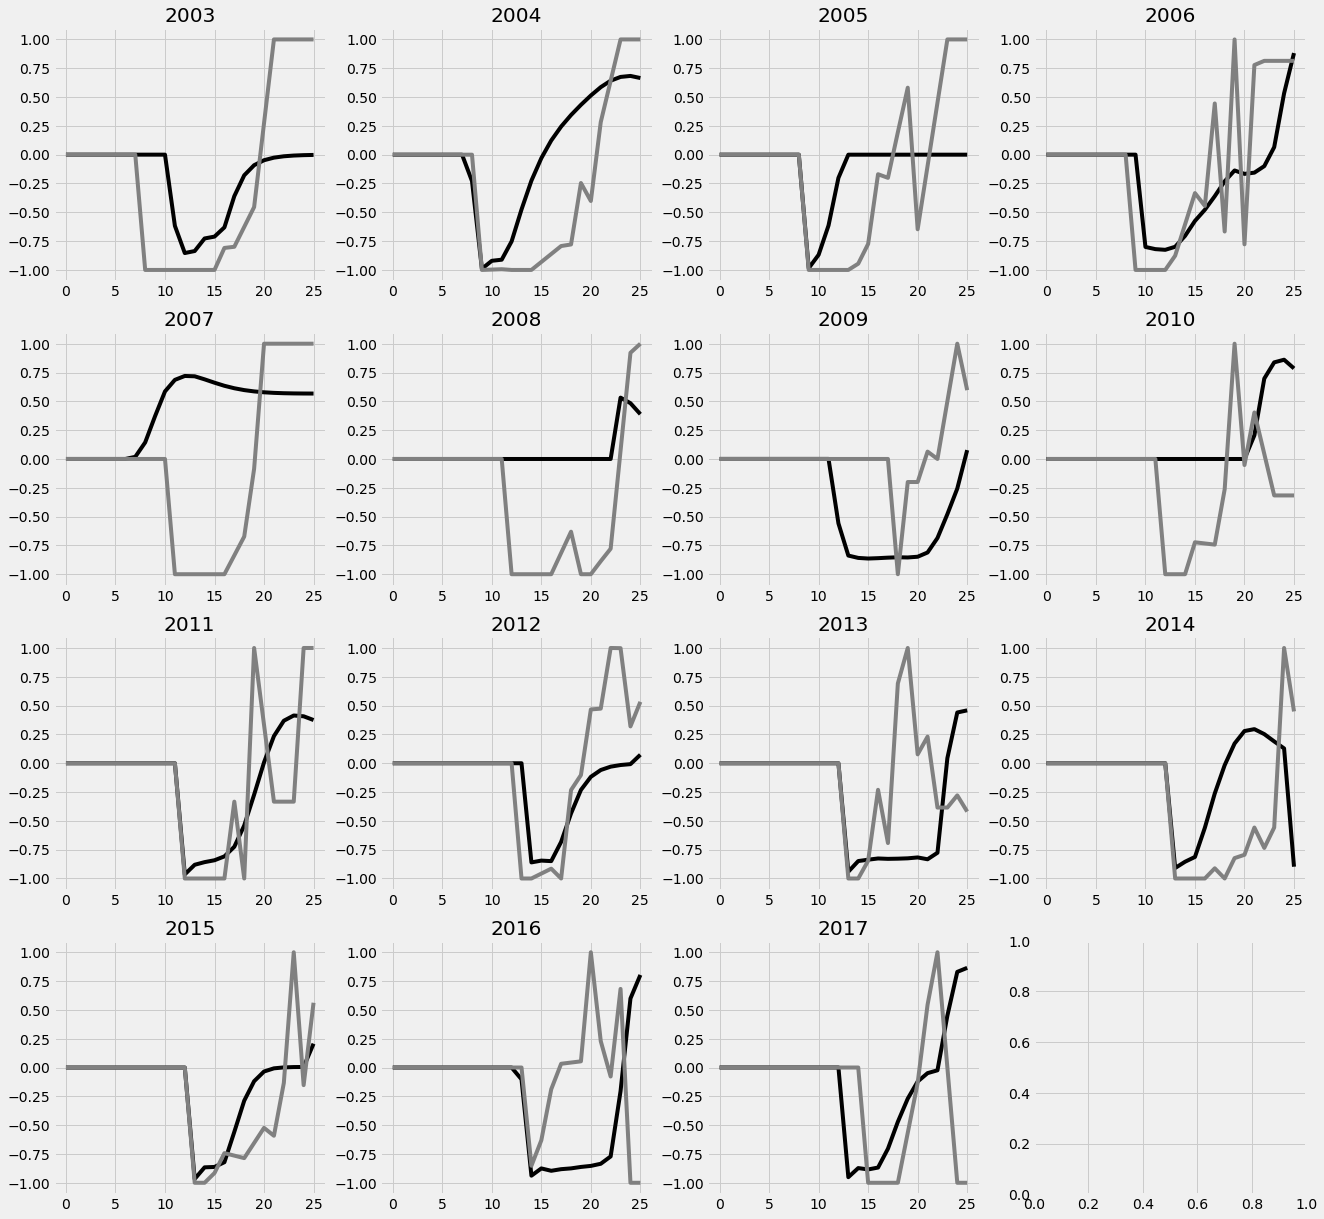

In [37]:
from sklearn.preprocessing import MinMaxScaler

lstm_info = {}

X_scale = np.copy(X)
scalers_x = {}
for i in range(X.shape[0]):
    scalers_x[i] = MinMaxScaler(feature_range=(-1, 1))
    X_scale[i, :, :] = scalers_x[i].fit_transform(X[i, :, :])
X_scale_nan = np.nan_to_num(X_scale)

Y_scale = np.copy(Y)
scalers_y = {}
for i in range(Y.shape[0]):
    scalers_y[i] = MinMaxScaler(feature_range=(-1, 1))
    Y_scale[i, :, :] = scalers_y[i].fit_transform(Y[i, :, :]) 
# Y_scale = np.nan_to_num(Y_scale)
Y_scale_nan = np.nan_to_num(Y_scale)

fig, ax = plt.subplots(nrows=4, ncols=4)
fig.set_figwidth(20)
fig.set_figheight(20)
ymax = 0
for j, year in enumerate(analysis_years):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.LSTM(64, input_shape=(26, 5),
                   return_sequences=True,
                   activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Dense(64))
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.LSTM(32, input_shape=(26, 5),
                   return_sequences=True,
                   activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Dense(32))
    model.add(tf.keras.layers.Dropout(0.5))
    
    model.add(tf.keras.layers.LSTM(16, input_shape=(26, 5),
                   return_sequences=True,
                   activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Dense(16))
    model.add(tf.keras.layers.Dropout(0.5))
    
    model.add(tf.keras.layers.LSTM(8, input_shape=(26, 5),
                   return_sequences=True,
                   activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Dense(8))
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(1))

    model.compile(optimizer='adam', 
                  loss='mae')
    ind = np.ones((len(analysis_years),), bool)
    ind[j] = False
    train_X = np.nan_to_num(X_scale_nan[ind])
    train_Y = np.nan_to_num(Y_scale_nan[ind])

    test_X = np.nan_to_num(X_scale_nan[j].reshape(1, X_scale_nan.shape[1], X_scale_nan.shape[2]))
    test_Y = np.nan_to_num(Y_scale_nan[j].reshape(1, Y_scale_nan.shape[1], Y_scale_nan.shape[2]))
    
    history = model.fit(train_X, train_Y, 
                    epochs=2000, batch_size=16,)
    
    train_predictions = model.predict(train_X)

    # Train MSE
    train_mse = metrics.mean_squared_error(train_Y.reshape(train_Y.shape[0], train_Y.shape[1] * train_Y.shape[2]),
                               train_predictions.reshape(train_predictions.shape[0], train_predictions.shape[1] * train_predictions.shape[2]))
    train_mae = metrics.mean_absolute_error(train_Y.reshape(train_Y.shape[0], train_Y.shape[1] * train_Y.shape[2]),
                               train_predictions.reshape(train_predictions.shape[0], train_predictions.shape[1] * train_predictions.shape[2]))
    
    test_predictions = model.predict(test_X)

    # Test RMSE
    test_mse = metrics.mean_squared_error(test_Y.reshape(test_Y.shape[0], test_Y.shape[1] * test_Y.shape[2]),
                               test_predictions.reshape(test_predictions.shape[0], test_predictions.shape[1] * train_predictions.shape[2]))
    test_mae = metrics.mean_absolute_error(test_Y.reshape(test_Y.shape[0], test_Y.shape[1] * test_Y.shape[2]),
                               test_predictions.reshape(test_predictions.shape[0], test_predictions.shape[1] * train_predictions.shape[2]))
    
    
    year_info = {
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'test_predictions_scaled': scalers_y[j].inverse_transform(test_predictions.reshape(-1, 1)),
        'test_predictions_unscaled': test_predictions.reshape(-1, 1)
    }
    
    lstm_info[year] = year_info
    
    jx = np.unravel_index(j, ax.shape)
    
    ax[jx].plot(test_predictions[0], color='black')
    ax[jx].plot(test_Y[0], color='gray')
    ax[jx].set_title(year)
    
    # Save for future use
    model.save(f'models/model_{year}.h5')

In [44]:
# Format for json
for key in lstm_info.keys():
    lstm_info[key]['test_predictions_scaled'] = lstm_info[key]['test_predictions_scaled'].tolist()
    lstm_info[key]['test_predictions_unscaled'] = lstm_info[key]['test_predictions_unscaled'].tolist()

# save to json
import json

with open('sufficient_info.json', 'w') as fp:
    json.dump(lstm_info, fp)

### Evaluate with saved models

In [ ]:
from sklearn.preprocessing import MinMaxScaler

lstm_info = {}
model_dir = 'models/'

X_scale = np.copy(X)
scalers_x = {}
for i in range(X.shape[0]):
    scalers_x[i] = MinMaxScaler(feature_range=(-1, 1))
    X_scale[i, :, :] = scalers_x[i].fit_transform(X[i, :, :])
X_scale_nan = np.nan_to_num(X_scale)

Y_scale = np.copy(Y)
scalers_y = {}
for i in range(Y.shape[0]):
    scalers_y[i] = MinMaxScaler(feature_range=(-1, 1))
    Y_scale[i, :, :] = scalers_y[i].fit_transform(Y[i, :, :]) 
# Y_scale = np.nan_to_num(Y_scale)
Y_scale_nan = np.nan_to_num(Y_scale)

for j, year in enumerate(analysis_years):
    model = tf.keras.models.load_model(f'{model_dir}model_{year}.h5')
    
    ind = np.ones((len(analysis_years),), bool)
    ind[j] = False
    train_X = np.nan_to_num(X_scale_nan[ind])
    train_Y = np.nan_to_num(Y_scale_nan[ind])

    test_X = np.nan_to_num(X_scale_nan[j].reshape(1, X_scale_nan.shape[1], X_scale_nan.shape[2]))
    test_X = test_predictions_given_first_n_data(test_X, 26)
    test_Y = np.nan_to_num(Y_scale_nan[j].reshape(1, Y_scale_nan.shape[1], Y_scale_nan.shape[2]))
    
    train_predictions = model.predict(train_X)

    # Train MSE
    train_mse = metrics.mean_squared_error(train_Y.reshape(train_Y.shape[0], train_Y.shape[1] * train_Y.shape[2]),
                               train_predictions.reshape(train_predictions.shape[0], train_predictions.shape[1] * train_predictions.shape[2]))
    train_mae = metrics.mean_absolute_error(train_Y.reshape(train_Y.shape[0], train_Y.shape[1] * train_Y.shape[2]),
                               train_predictions.reshape(train_predictions.shape[0], train_predictions.shape[1] * train_predictions.shape[2]))
    
    test_predictions = model.predict(test_X)

    # Test RMSE
    test_mse = metrics.mean_squared_error(test_Y.reshape(test_Y.shape[0], test_Y.shape[1] * test_Y.shape[2]),
                               test_predictions.reshape(test_predictions.shape[0], test_predictions.shape[1] * train_predictions.shape[2]))
    test_mae = metrics.mean_absolute_error(test_Y.reshape(test_Y.shape[0], test_Y.shape[1] * test_Y.shape[2]),
                               test_predictions.reshape(test_predictions.shape[0], test_predictions.shape[1] * train_predictions.shape[2]))
    
    
    year_info = {
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'test_predictions_scaled': scalers_y[j].inverse_transform(test_predictions.reshape(-1, 1)),
        'test_predictions': test_predictions.reshape(-1, 1)
    }
    
    lstm_info[year] = year_info

In [ ]:
lstm_info

In [59]:
# Format for json
for key in lstm_info.keys():
# for key in list(range(2004, 2018)):
    lstm_info[key]['test_predictions_scaled'] = lstm_info[key]['test_predictions_scaled'].tolist()

# save to json
import json

with open('sufficient_info_june.json', 'w') as fp:
    json.dump(lstm_info, fp)

Example code for data augmentation

In [ ]:
# from sklearn.preprocessing import MinMaxScaler

# X_scale = np.copy(X)
# scalers_x = {}
# for i in range(X.shape[1]):
#     scalers_x[i] = MinMaxScaler(feature_range=(-1, 1))
#     X_scale[:, i, :] = scalers_x[i].fit_transform(X[:, i, :])
# X_scale_nan = np.nan_to_num(X_scale)

# # Augmenting training data - X
# X_reverse_time = reverse_time_series(X_scale_nan)
# X_reverse_magnitude = X_scale_nan * -1
# X_reverse_both = reverse_time_series(X_scale_nan) * -1

# # X_augmented = np.concatenate([X_scale_nan, X_reverse_time, X_reverse_magnitude, X_reverse_both])
# X_augmented = np.concatenate([X_scale_nan, X_reverse_time])

# Y_scale = np.copy(Y)
# scalers_y = {}
# for i in range(Y.shape[1]):
#     scalers_y[i] = MinMaxScaler(feature_range=(-1, 1))
#     Y_scale[:, i, :] = scalers_y[i].fit_transform(Y[:, i, :]) 
# # Y_scale = np.nan_to_num(Y_scale)
# Y_scale_nan = np.nan_to_num(Y_scale)

# # Augmenting training data - Y
# Y_reverse_time = reverse_time_series(Y_scale_nan)
# Y_reverse_magnitude = Y_scale_nan * -1
# Y_reverse_both = reverse_time_series(Y_scale_nan) * -1

# # Y_augmented = np.concatenate([Y_scale_nan, Y_reverse_time, Y_reverse_magnitude, Y_reverse_both])
# Y_augmented = np.concatenate([Y_scale_nan, Y_reverse_time])